 <h1 align = "center"> <font color=red> BANK PERSONAL LOAN - Machine Learning Models </font> </h1> 

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px"> 1. OVERVIEW </div>

This notebook is to conduct different types of ML model to predict customer taking loans:
1. Logistic Regression
2. Boosting techniques
3. Random Forest
4. Gaussian based techniques: Naive Bayes, LDA, QDA
5. KNN
6. DNN

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px"> 2. SET UP </div>

## <font color=red> 2.1. Import library

In [3]:
import sys
# Python ≥3.5 is required
assert sys.version_info >= (3, 5)
from pathlib import Path
import os

# Dataframe manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import plotly as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, Normalizer, scale

# Modelling Helpers:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate
from sklearn.feature_selection import RFECV

# statsmodels and math lib
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels as statm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import math
from math import sqrt

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Evaluation metrics for Classification
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import log_loss
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

#!pip install zipcodes
#!pip install pgeocode
import zipcodes as zcode
import pgeocode

# Save model
import joblib

# sns.set(style = 'whitegrid',context = 'notebook')
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


## <font color=red> 2.2. Define Function

In [4]:
def get_metrics(true_labels, predicted_labels, predicted_prob):
    
    print('Accuracy:', np.round(accuracy_score(true_labels, predicted_labels),4))
    print('Precision:', np.round(precision_score(true_labels, predicted_labels,average='weighted'),4))
    print('Recall:', np.round(recall_score(true_labels,predicted_labels,average='weighted'),4))
    print('F1 Score:', np.round(f1_score(true_labels,predicted_labels,average='weighted'),4))
    print('ROC-AUC: {}'.format(np.round(roc_auc_score(true_labels, predicted_prob),4)))                   

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[0,1]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels,labels=classes)
    cm_df = pd.DataFrame(cm)
    cm_df = cm_df.sort_index(ascending=False)
    cm_df = cm_df[[1,0]]    
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    print(cm_df)    
  
    
def display_classification_report(true_labels, predicted_labels, classes=[0,1]):

    report = classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report) 
    
def display_model_performance_metrics(true_labels, predicted_labels, predicted_prob, classes=[0,1]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels, predicted_prob=predicted_prob)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, classes=classes)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px"> 3. DATA PREPARATION </div>

## <font color=red> 3.1. Import Data
    
Load preprocessed data that was done in previous step to build predictive models

In [5]:
df_train = pd.read_csv('train_df.csv')
df_test = pd.read_csv('test_df.csv')

print(df_train.shape, df_test.shape)
print(df_train.Class.sum()/len(df_train), df_test.Class.sum()/len(df_test))

(4000, 12) (1000, 12)
0.0975 0.09


In [6]:
df_train.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Class,Securities_Account,CD_Account,Online,CreditCard
0,39,12,75,3,2.33,2,0,0,0,0,1,1
1,32,8,65,1,1.20,1,268,0,0,0,1,0
2,65,39,23,3,0.70,2,0,0,0,0,0,1
3,39,14,74,3,3.00,1,0,0,0,0,0,0
4,46,21,41,1,1.40,3,128,0,0,0,1,0


## <font color=red>3.2. Split data into X & y

In [7]:
df_train = df_train.reset_index(drop=True)
X_train = df_train.drop(['Class'], axis=1)
y_train = df_train.Class

df_test = df_test.reset_index(drop=True)
X_test = df_test.drop(['Class'], axis=1)
y_test = df_test.Class

## <font color=red>3.3. Apply Feature Scaling for Logistic Regression Model

In [8]:
Scaler = MinMaxScaler(feature_range = (0,1))
scaled_train = pd.DataFrame(Scaler.fit_transform(X_train), columns = list(X_train.columns))
scaled_test = pd.DataFrame(Scaler.transform(X_test), columns = list(X_test.columns))

scaled_train.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard
0,0.363636,0.279070,0.310185,0.666667,0.233,0.5,0.000000,0.0,0.0,1.0,1.0
1,0.204545,0.186047,0.263889,0.000000,0.120,0.0,0.422047,0.0,0.0,1.0,0.0
2,0.954545,0.906977,0.069444,0.666667,0.070,0.5,0.000000,0.0,0.0,0.0,1.0
3,0.363636,0.325581,0.305556,0.666667,0.300,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.522727,0.488372,0.152778,0.000000,0.140,1.0,0.201575,0.0,0.0,1.0,0.0


In [9]:
TRAIN_VARS = X_train.columns
print('All training vars: ', TRAIN_VARS)

All training vars:  Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard'], dtype='object')


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px"> 4. PREDICTIVE MODELS </div>

---
## <font color=red>4.1. Logistic Regression using stats model

### <font color=blue>1. Overview

Logistic Regression predicts the probability of an event occuring and has the form  

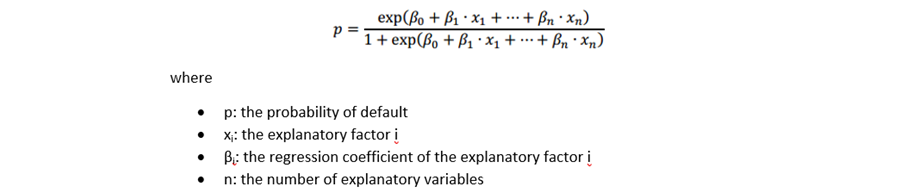
    
for each of the existing data points, it calculates the probability of class 1. The aim here is to find the coefficients such that the model's probability of class 1 equals to the observed probability of class 1. Typically, this is done through maximum likelihood    

### <font color=blue>2. Train model and Result

In [10]:
import statsmodels.api as sm

# add constant
X_train_const = sm.add_constant(scaled_train[TRAIN_VARS])
X_test_const = sm.add_constant(scaled_test[TRAIN_VARS])

# train model
model = sm.Logit(y_train, X_train_const)
result = model.fit()

# view result
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.130420
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3988
Method:                           MLE   Df Model:                           11
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.5919
Time:                        05:03:21   Log-Likelihood:                -521.68
converged:                       True   LL-Null:                       -1278.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.4526      0.532    -19.633      0.000     -11.496      -9.409
Age  

<div style="float:left;margin-left:20px; max-width:100%; text-align:justify;
          padding:15px;
          background-color:#E5E4E2;
          margin:0;
          border-radius: 13px 13px;
          overflow:hidden;">
<p>Summary table shows the result of logistic regression estimates of various factors influencing customers taking personal loan. Howerver, features Age, Experience, Mortgage are not statistically significant due to having p> 0.05 . Including unnesscary features may cause some problems for logistic regression such as overfitting, unreasonable interpretation. Therefore, feature selection should be performed to eliminates these features.  
</div>

### <font color=blue>3. Feature Selection
    
The following are common approaches for Feature Selection for Logistic Regression

#### Step forward

In forward selection, we start with a null model and then start fitting the model with each individual feature one at a time and select the feature with the minimum p-value. Then, continue to fit a model with two features by trying combinations of the earlier selected feature with all other remaining features. Again select the feature with the minimum p-value. Next, it fit a model with three features by trying combinations of two previously selected features with other remaining features. Repeat this process until we have a set of selected features with a p-value of individual features less than the significance level.

In short, the steps for the forward selection technique are as follows :

1. Choose a significance level (e.g. SL = 0.05 with a 95% confidence).

2. Fit all possible simple regression models by considering one feature at a time. Total ’n’ models are possible. Select the feature with the lowest p-value.

3. Fit all possible models with one extra feature added to the previously selected feature(s).

4. Again, select the feature with a minimum p-value. if p_value < significance level then go to Step 3, otherwise terminate the process.

In [24]:
def forward_selection(data, target, sl=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features) > 0):
        remaining_features = list(set(initial_features) - set(best_features))
        new_pvalue = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            print(new_column)
            model = sm.Logit(target, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pvalue[new_column] = model.pvalues[new_column]
        min_pvalue = new_pvalue.min()
        if(min_pvalue < sl):
            best_features.append(new_pvalue.idxmin())
        else:
            break
    return best_features

best_features = forward_selection(scaled_train[TRAIN_VARS],y_train)

Family
Optimization terminated successfully.
         Current function value: 0.317723
         Iterations 6
CreditCard
Optimization terminated successfully.
         Current function value: 0.319521
         Iterations 6
CCAvg
Optimization terminated successfully.
         Current function value: 0.268965
         Iterations 7
Securities_Account
Optimization terminated successfully.
         Current function value: 0.319112
         Iterations 6
Age
Optimization terminated successfully.
         Current function value: 0.319427
         Iterations 6
Online
Optimization terminated successfully.
         Current function value: 0.319532
         Iterations 6
Education
Optimization terminated successfully.
         Current function value: 0.309094
         Iterations 7
Mortgage
Optimization terminated successfully.
         Current function value: 0.310723
         Iterations 6
CD_Account
Optimization terminated successfully.
         Current function value: 0.291501
         Iterations 

In [22]:
print('Original vars: ', TRAIN_VARS)
print('Selected vars: ', best_features)
print('Removed vars: ', list(set(TRAIN_VARS) - set(best_features)))

Original vars:  Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard'], dtype='object')
Selected vars:  ['Income', 'Education', 'CD_Account', 'Family', 'CreditCard', 'Online', 'CCAvg', 'Securities_Account']
Removed vars:  ['Age', 'Mortgage', 'Experience']


#### Step backward eliminination

In backward elimination, we start with the full model (including all the independent variables) and then remove the insignificant feature with the highest p-value(> significance level). This process repeats again and again until we have the final set of significant features.

In short, the steps involved in backward elimination are as follows:

1. Choose a significance level (e.g. SL = 0.05 with a 95% confidence).

2. Fit a full model including all the features.

3. Consider the feature with the highest p-value. If the p-value > significance level then go to Step 4, otherwise terminate the process.

4. Remove the feature which is under consideration.

Fit a model without this feature. Repeat the entire process from Step 3.

In [19]:
def backward_elimination(data, target, sl=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.Logit(target, features_with_constant).fit().pvalues[1:]
        max_pvalue = p_values.max()
        if (max_pvalue >= sl):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

best_features = backward_elimination(scaled_train[TRAIN_VARS],y_train)

Optimization terminated successfully.
         Current function value: 0.130420
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.130512
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.130637
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.130982
         Iterations 9


In [20]:
print('Original vars: ', TRAIN_VARS)
print('Selected vars: ', best_features)
print('Removed vars: ', list(set(TRAIN_VARS) - set(best_features)))

Original vars:  Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard'], dtype='object')
Selected vars:  ['Income', 'Family', 'CCAvg', 'Education', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']
Removed vars:  ['Age', 'Mortgage', 'Experience']


#### Bi-directional elimination(Step-wise Selection)

It is similar to forward selection but the difference is while adding a new feature it also checks the significance of already added features and if it finds any of the already selected features insignificant then it simply removes that particular feature through backward elimination.

Hence, It is a combination of forward selection and backward elimination.

In short, the steps involved in bi-directional elimination are as follows:

1. Choose a significance level to enter and exit the model (e.g. SL_in = 0.05 and SL_out = 0.05 with 95% confidence).

2. Perform the next step of forward selection (newly added feature must have p-value < SL_in to enter).

3. Perform all steps of backward elimination (any previously added feature with p-value>SL_out is ready to exit the model).

Repeat steps 2 and 3 until we get a final optimal set of features.

In [25]:
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            print(new_column)
            model = sm.Logit(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.Logit(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

best_features = stepwise_selection(scaled_train[TRAIN_VARS],y_train)

Family
Optimization terminated successfully.
         Current function value: 0.317723
         Iterations 6
CreditCard
Optimization terminated successfully.
         Current function value: 0.319521
         Iterations 6
CCAvg
Optimization terminated successfully.
         Current function value: 0.268965
         Iterations 7
Securities_Account
Optimization terminated successfully.
         Current function value: 0.319112
         Iterations 6
Age
Optimization terminated successfully.
         Current function value: 0.319427
         Iterations 6
Online
Optimization terminated successfully.
         Current function value: 0.319532
         Iterations 6
Education
Optimization terminated successfully.
         Current function value: 0.309094
         Iterations 7
Mortgage
Optimization terminated successfully.
         Current function value: 0.310723
         Iterations 6
CD_Account
Optimization terminated successfully.
         Current function value: 0.291501
         Iterations 

In [26]:
print('Original vars: ', TRAIN_VARS)
print('Selected vars: ', best_features)
print('Removed vars: ', list(set(TRAIN_VARS) - set(best_features)))

Original vars:  Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard'], dtype='object')
Selected vars:  ['Income', 'Education', 'CD_Account', 'Family', 'CreditCard', 'Online', 'CCAvg', 'Securities_Account']
Removed vars:  ['Age', 'Mortgage', 'Experience']


### <font color=blue>4. Re-train with important features

In [28]:
import statsmodels.api as sm

# add constant
X_train_const = sm.add_constant(scaled_train[best_features])
X_test_const = sm.add_constant(scaled_test[best_features])

# train model
lg = sm.Logit(y_train, X_train_const)
result = lg.fit()

# view result
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.130982
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3991
Method:                           MLE   Df Model:                            8
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                  0.5901
Time:                        05:07:22   Log-Likelihood:                -523.93
converged:                       True   LL-Null:                       -1278.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.3472      0.471    -21.974      0.000     -11.270      -9.424
Incom

<div style="float:left;margin-left:20px; max-width:100%; text-align:justify;
          padding:15px;
          background-color:#E5E4E2;
          margin:0;
          border-radius: 13px 13px;
          overflow:hidden;">
<p> Now, features 'Age', 'Experience', 'Mortgage' are removed from final model, all the remaining features are statistically significant with p-value < 0.05                                                   
</div>

### <font color=blue>5. Feature Importance

In [31]:
pd.set_option('display.float_format', lambda x: '%.3f' %x)
pd.DataFrame({'coef': result.params, 'p-value': round(result.pvalues,3)})

,coef,p-value
const,-10.347,0.000
Income,11.570,0.000
Education,3.535,0.000
CD_Account,3.785,0.000
Family,1.967,0.000
CreditCard,-1.108,0.000
Online,-0.739,0.000
CCAvg,1.468,0.001
Securities_Account,-0.760,0.011


In [32]:
 result.params[1:]

Income               11.570
Education             3.535
CD_Account            3.785
Family                1.967
CreditCard           -1.108
Online               -0.739
CCAvg                 1.468
Securities_Account   -0.760
dtype: float64

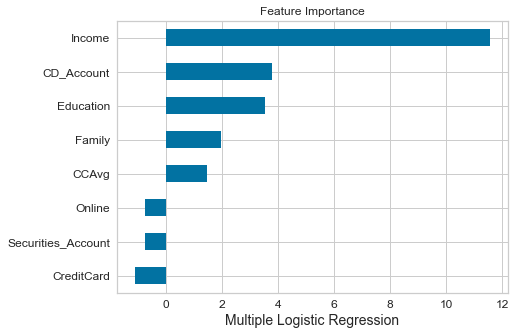

In [33]:
feature_importance = result.params[1:]
feature_importance.sort_values(inplace=True, ascending=True)
feature_importance.plot.barh(figsize=(7,5))
plt.xlabel('Multiple Logistic Regression')
plt.title('Feature Importance')
plt.show()

---

## <font color=red>4.2. Logistic Regression with sklearn

### <font color=blue>1. Train model

In [34]:
print(best_features)

['Income', 'Education', 'CD_Account', 'Family', 'CreditCard', 'Online', 'CCAvg', 'Securities_Account']


In [37]:
scaled_train[best_features]

,Income,Education,CD_Account,Family,CreditCard,Online,CCAvg,Securities_Account
0,0.310,0.500,0.000,0.667,1.000,1.000,0.233,0.000
1,0.264,0.000,0.000,0.000,0.000,1.000,0.120,0.000
2,0.069,0.500,0.000,0.667,1.000,0.000,0.070,0.000
3,0.306,0.000,0.000,0.667,0.000,0.000,0.300,0.000
4,0.153,1.000,0.000,0.000,0.000,1.000,0.140,0.000
...,...,...,...,...,...,...,...,...
3995,0.218,1.000,0.000,0.000,0.000,1.000,0.140,0.000
3996,0.491,1.000,0.000,1.000,0.000,1.000,0.240,0.000
3997,0.074,1.000,0.000,0.333,1.000,0.000,0.090,0.000
3998,0.190,0.000,1.000,1.000,1.000,1.000,0.150,1.000


In [39]:
y_train.sum()

390

In [41]:
from sklearn.linear_model import LogisticRegression

# train model
#lg = LogisticRegression(C=1e20, penalty='l2', solver='liblinear')
lg = LogisticRegression()
lg.fit(scaled_train[best_features], y_train)

LogisticRegression()

### <font color=blue>2. Prediction

In [73]:
y_train_pred = lg.predict(scaled_train[best_features])
prob_train_pred = lg.predict_proba(scaled_train[best_features])

y_test_pred = lg.predict(scaled_test[best_features])
prob_test_pred = lg.predict_proba(scaled_test[best_features])

### <font color=blue>3. Model Result

#### Estimated parameters: intercept and coefficients

In [43]:
print('Intercept: ', lg.intercept_)
print('Coefficients: ', lg.coef_)
lg.coef_.shape

Intercept:  [-8.47925367]
Coefficients:  [[ 8.81005887  2.80864604  3.11308982  1.54168743 -0.8887224  -0.58887831
   1.7659679  -0.58960315]]


(1, 8)

#### Feature Importance

In [45]:
lg.coef_.ravel()

array([ 8.81005887,  2.80864604,  3.11308982,  1.54168743, -0.8887224 ,
       -0.58887831,  1.7659679 , -0.58960315])

<Axes: >

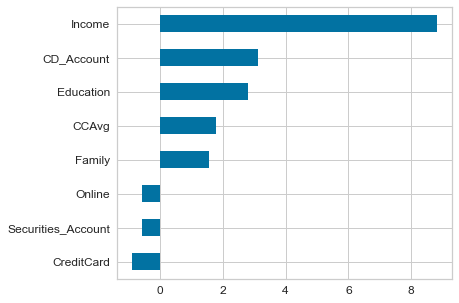

In [47]:
feature_importance = pd.Series(lg.coef_.ravel())
feature_importance.index = best_features
feature_importance.sort_values(inplace=True, ascending=True)
feature_importance.plot.barh(figsize=(6,5))

#### Summary Table

In [53]:
def LogisticSummaryTable(model, feature_list):
    summary_table = pd.DataFrame()
    summary_table['FeatureName'] = ['const'] + feature_list
    summary_table['Coefficient'] = [model.intercept_[0]] + list(model.coef_.ravel())
    # summary_table = summary_table.append({"FeatureName": 'const', "Coefficient": model.intercept_[0]}, ignore_index=True)   
    summary_table['OddsRatio'] = np.exp(summary_table['Coefficient'])
    summary_table = summary_table.sort_values('Coefficient', ascending=False)
    
    return summary_table

pd.set_option('display.float_format', lambda x: '%.5f' %x)
LogisticSummaryTable(lg, best_features)

,FeatureName,Coefficient,OddsRatio
1,Income,8.81006,6701.31377
3,CD_Account,3.11309,22.49043
2,Education,2.80865,16.58744
7,CCAvg,1.76597,5.84723
4,Family,1.54169,4.67247
6,Online,-0.58888,0.55495
8,Securities_Account,-0.58960,0.55455
5,CreditCard,-0.88872,0.41118
0,const,-8.47925,0.00021


**Table Interpretation**
<div style="float:left;margin-left:20px; max-width:100%; text-align:justify;
          padding:15px;
          background-color:#E5E4E2;
          margin:0;
          border-radius: 13px 13px;
          overflow:hidden;">
<p> 
Table shows the result of logistic regression estimates of the various factors including customer taking personal loan:
<p>📌 Column Coefficient indicates the contribution of each predictor variable. The most important variables are Income, CD_Account, Education
<p>📌 Columns OddsRatio show the change in the probability of taking loan if the variable changes by one unit. 
    
</div>

### <font color=blue>4. Performance Evaluation 
    
The following are common metrics to evaluate performance for classificaiton models. These metrics are measured on the Train-Test split or Cross-validation methods    
+ Accuracy
+ The area under the curve (AUC) of the receiver operating characteristic (ROC) curve
+ Sensitivity
+ Specificity
+ Positve predictive value [PPV]
+ Negative predictive value [NPV]

#### Confusion Matrix

1. Confusion matrix is a matrix that can be used to give the quick overview of the model by comparing the predicted class label of a data point with its actual class label. Each row of the confusion matrix represents the instances of an actual class and each column represents the instances of a predicted class. But it can be the other way around as well, i.e. rows for predicted classes and columns for actual classes

2. The confusion matrix by itself is not a performance measure for classification models, but it can be used to calcualte several metrics that are useful measures for different scenarios

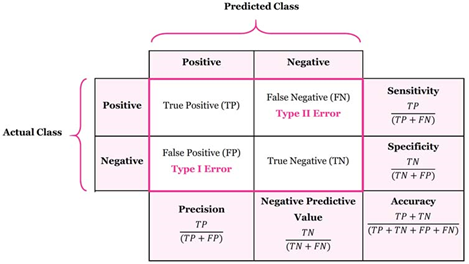

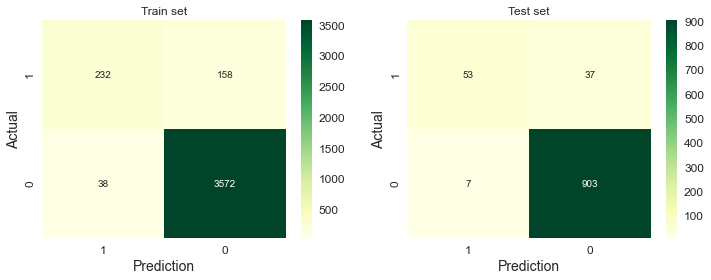

In [55]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm)
    cm_df = cm_df.sort_index(ascending=False)
    cm_df = cm_df[[1,0]]
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Prediction'
    
    return cm_df

plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(create_confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='YlGn')
plt.title('Train set')
plt.subplot(122)
sns.heatmap(create_confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='YlGn')
plt.title('Test set')
plt.show()

In [56]:
create_confusion_matrix(y_train, y_train_pred)

Prediction,1,0
Actual,,
1,232,158
0,38,3572


#### Accuracy score

This is one of the most popular measures of classifier performance. It is defined as the overall accuracy or proportion of correct predictions of the model
+ Accuracy measure is normally used when our classes are almost balanced and correct predictions of those classes are equally important
+ **In case data is imbalanced, the accuracy is not adequate**. For example, we have 1000 samples, 995 of theses are negative and 5 are positive cases. Assume that there is a classifier, which classifies whatever it will be presented as negative. The accuracy is a surprising 99.5%, even though the classifier could not recognize any positive examples

In [57]:
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.951, 0.956)

#### Classification Report

Provide precision and recall score of each class

In [58]:
print("precision and recall of class 1:", 232/(249+38),  232/(232+158))
print("precision and recall of class 0:", 3572/(3572+158), 3572/(3550+38))

precision and recall of class 1: 0.8083623693379791 0.5948717948717949
precision and recall of class 0: 0.9576407506702412 0.9955406911928651


In [62]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3610
           1       0.86      0.59      0.70       390

    accuracy                           0.95      4000
   macro avg       0.91      0.79      0.84      4000
weighted avg       0.95      0.95      0.95      4000

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       910
           1       0.88      0.59      0.71        90

    accuracy                           0.96      1000
   macro avg       0.92      0.79      0.84      1000
weighted avg       0.95      0.96      0.95      1000



#### ROC and AUC

1. The ROC curve (Receiver operating characteristic) is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. Or The ROC curve reflects the relationship between the (1-specificity) and sensitivity. A good classifier aims for the upper left for the ROC curve. Intuitively, ROC tells us that if we are trying to improtve the accuracy rate of predicted class 1 within the actual class 1 by decreasing the cut of point, then the accuracy rate of predicted class 0 within the actual class 0 will generally decrease
2. The AUC (area under the curve) is the C statistic and it indicates the performance of the model. The higher means the more 'agreement' between the model and the acutal data

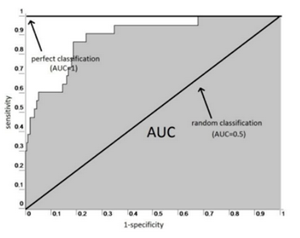

In [63]:
y_train.shape, prob_train_pred.shape

((4000,), (4000, 2))

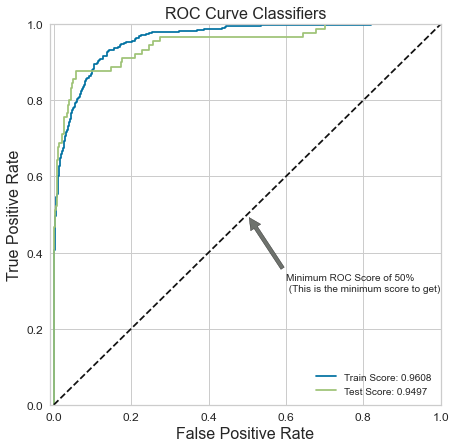

In [75]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y_train, prob_train_pred, y_test, prob_test_pred):
    fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
    fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])
    
    plt.figure(figsize=(7,7))
    plt.title('ROC Curve Classifiers', fontsize=16)
    plt.plot(fpr_train, tpr_train, label='Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
    plt.plot(fpr_test, tpr_test, label='Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)',
                xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.legend()
    plt.show()
    
plot_roc_curve(y_train, prob_train_pred, y_test, prob_test_pred)    

#### Recall and the Decision Boundary T

Shows the tradeoff between recall rates of 2 classes for different thresholds, based on this trade-off, we can select a threshold that are most suitable for the business requirement

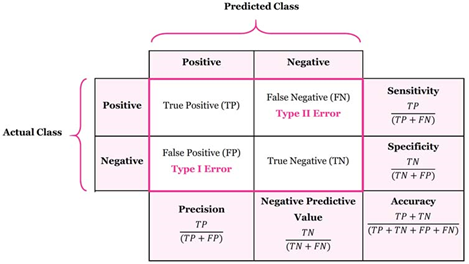

In [76]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def precision_recall_threshold(pred_proba, label):
    t_recall_0, t_recall_1 = [], []
    t_precision_0, t_precision_1 = [], []
    
    for threshold in np.arange(0, 1, 0.01):
        precision, recall, fscore, support = \
            metrics.precision_recall_fscore_support(label, np.where(pred_proba[:,1] > threshold, 1, 0))
        recall_0, recall_1 = recall
        precision_0, precision_1 = precision
            
        t_recall_0.append(recall_0)
        t_recall_1.append(recall_1)
        t_precision_0.append(precision_0)
        t_precision_1.append(precision_1)
    return t_precision_0, t_precision_1, t_recall_0, t_recall_1

def plot_recall_vs_decision_boundary(t_recall_1,t_recall_0,threshold,filename = 'Recall_score.png'):
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(0,1,0.01), t_recall_1, label='Class1')
    plt.plot(np.arange(0,1,0.01), t_recall_0, label='Class0')
    plt.plot([.5, .5], [0,1], 'k--')
    plt.plot([threshold, threshold], [0,1], 'k--')
    plt.ylim([0.0, 1.01])
    plt.xlim([0.0, 1.01])
    plt.legend(loc='upper left', fontsize = 14)
    plt.title('Recall vs. Decision Boundary\n'
              'using Logistic Regression Classifier',
              fontsize=14)
    plt.xlabel('Decision Boundary (T)', fontsize=14)
    plt.ylabel('Recall Rate', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig(filename)
    plt.show()

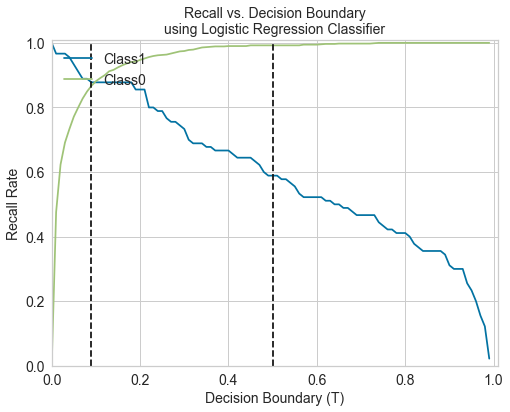

In [77]:
t_precision_0, t_precision_1, t_recall_0, t_recall_1 = precision_recall_threshold(prob_test_pred, y_test)
plot_recall_vs_decision_boundary(t_recall_1, t_recall_0, .09)

#### Select threshold = 0.1

In [78]:
tr = 0.1
y_train_pred = np.where(prob_train_pred[:,1] > tr, 1, 0)
y_test_pred = np.where(prob_test_pred[:,1] > tr,1 , 0)

prediction_df = pd.DataFrame()
prediction_df['True_Outcome'] = y_test
prediction_df['Prediction'] = y_test_pred
prediction_df['Probability'] = prob_test_pred[:,1]

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.8772
Precision: 0.935
Recall: 0.8772
F1 Score: 0.8949
ROC-AUC: 0.9608

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3610
           1       0.44      0.91      0.59       390

    accuracy                           0.88      4000
   macro avg       0.71      0.89      0.76      4000
weighted avg       0.93      0.88      0.89      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          354    36
0          455  3155

Model Performance metrics:
------------------------------
Accuracy: 0.881
Precision: 0.9357
Recall: 0.881
F1 Score: 0.8985
ROC-AUC: 0.9497

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       910
           1     

**Interpretation**
<div style="float:left;margin-left:20px; max-width:100%; text-align:justify;
          padding:15px;
          background-color:#E5E4E2;
          margin:0;
          border-radius: 13px 13px;
          overflow:hidden;">
<p> 

<p>📌 At the default decision boundary of T = 0.5, the recall rate for class1 is round 0.6, meaning that 60% of the time we classify a customer taking loan is correct and the recall rate for class1 is round 0.99, meaning that 99% of the time we classify a customer taking loan is correct. 
<p>📌 Since our objective is to maximize our ability to identify customers accept the loan, we can shift decision boundary to a point which would allow us to identify at least 90% of the time. To achieve this, we shifted out decision boundary leftward to T = 0.09, where the recall rate for class1 is 0.9, and coincidentally, the recall rate for class 1 is also 0.9. This means that by shifting our decision boundary, we were able to identify many more default, only having to sacrifice a recall rate of less than 10% on the class0 
    
</div>

#### Precision-Recall curve

Shows the tradeoff between precision and recall for different thresholds: For each instance, it computes a score based on decision function, and if score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class

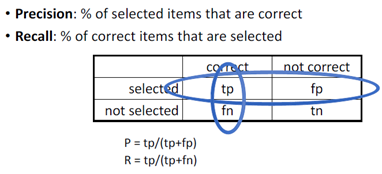

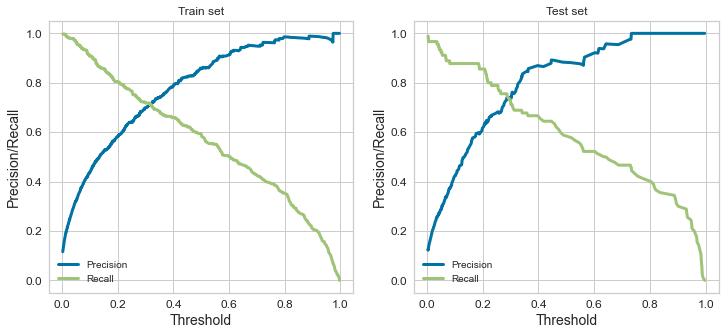

In [79]:
def select_threshold(label, y_score):
    precision, recall, threshold = precision_recall_curve(label, y_score)
    
    plt.plot(threshold, precision[1:], label='Precision', linewidth=3)
    plt.plot(threshold, recall[1:], label='Recall', linewidth=3)
    plt.title('Precision and recall for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    
plt.figure(figsize=(12,5))
plt.subplot(121)
select_threshold(y_train, prob_train_pred[:,1])
plt.title('Train set')
plt.subplot(122)
select_threshold(y_test, prob_test_pred[:,1])
plt.title('Test set')
plt.show()    

**Interpretation**
<div style="float:left;margin-left:20px; max-width:100%; text-align:justify;
          padding:15px;
          background-color:#E5E4E2;
          margin:0;
          border-radius: 13px 13px;
          overflow:hidden;">
<p> 
At the default, threshold = 0.5, the recall rate is around 0.6, meaning that only 60% of the time we classify a customers in class 1 correctly. Since our objective is to maximize the ability, we decide to shift our decision boundary to a point which would allow us to identify the event at least 70% of the time. To achive this, we shift the threshold to round 0.3, but we have to sacrifice the precision to approximately 0.7. 
    
</div>

Another way to select a good precision/recall trade off is to plot precision directly against recall. You will probably want to select a precision/recall tradeoff just before the drop - at around 60% recall. But of course the choice depends on the project

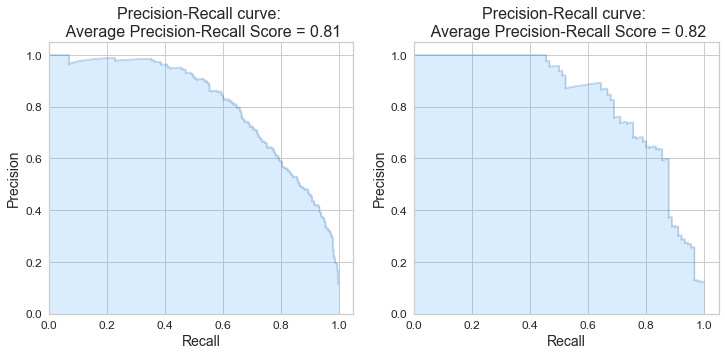

In [80]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_average_precision(label, y_score):
    precision, recall, threshold = precision_recall_curve(label, y_score)
    average_precision = average_precision_score(label, y_score)
    plt.step(recall, precision, color='#004a93', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall curve: \n Average Precision-Recall Score = {0:0.2f}'.format(average_precision), fontsize=16)
    
plt.figure(figsize=[12,5])
plt.subplot(121)
plot_average_precision(y_train, prob_train_pred[:,1])
# plt.title('Train set')
plt.subplot(122)
plot_average_precision(y_test, prob_test_pred[:,1])
# plt.title('Test set')

#### Select threshold = 0.3

In [81]:
tr = 0.3
y_train_pred = np.where(prob_train_pred[:,1] > tr, 1, 0)
y_test_pred = np.where(prob_test_pred[:,1] > tr,1 , 0)

prediction_df = pd.DataFrame()
prediction_df['True_Outcome'] = y_test
prediction_df['Prediction'] = y_test_pred
prediction_df['Probability'] = prob_test_pred[:,1]

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.9425
Precision: 0.9433
Recall: 0.9425
F1 Score: 0.9429
ROC-AUC: 0.9608

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3610
           1       0.70      0.72      0.71       390

    accuracy                           0.94      4000
   macro avg       0.83      0.84      0.84      4000
weighted avg       0.94      0.94      0.94      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          281   109
0          121  3489

Model Performance metrics:
------------------------------
Accuracy: 0.953
Precision: 0.9528
Recall: 0.953
F1 Score: 0.9529
ROC-AUC: 0.9497

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       910
           1    

#### Perform 10-fold cross-validation for logistic Regression

We train the model on the training set, and we test the accuracy of the model on the test set. That’s correct but we may have the variance problem. The variance problem can be explained by the fact that when we get the accuracy on the test set, and then we run the model again and test the performance on another test set. We can get very different accuracy. So, testing the accuracy of the model only on one training set and one test set is not good enough to evaluate the performance

K-Folds Cross Validation help to avoid underfitting as well as overfitting. The aim is to be able to generalize the model to new datasets with same accuracy. In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once

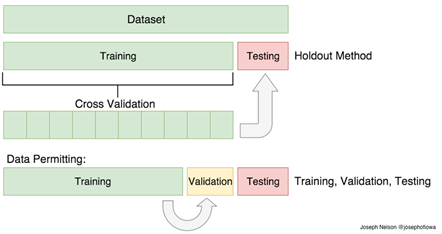


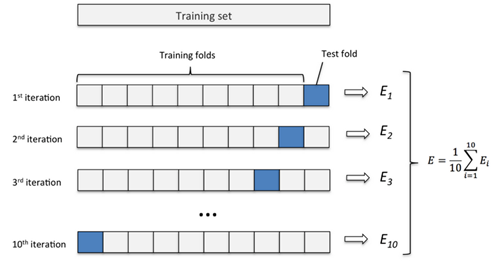

In [82]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
scores = cross_val_score(model, scaled_train[best_features], y_train, cv=10, scoring='roc_auc')
print(scores)
print('ROC AUC: %0.2f%% (+/- %0.2f%%)' % (100*scores.mean(), 100*scores.std()))
pd.Series(scores).describe()

[0.95809361 0.96505434 0.94580581 0.95915903 0.96683003 0.96299453
 0.9595852  0.96540948 0.96491228 0.95766745]
ROC AUC: 96.06% (+/- 0.59%)


count   10.00000
mean     0.96055
std      0.00617
min      0.94581
25%      0.95836
50%      0.96129
75%      0.96502
max      0.96683
dtype: float64

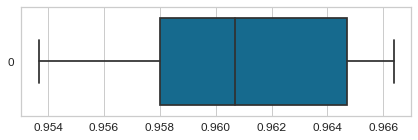

In [84]:
plt.figure(figsize=(7,2))
sns.boxplot(data=scores, orient='h')
plt.show()

### <font color=blue>5. Tuning hyper-parameters 
    
1. Hyperparameters are not learned by the model, we choose ourselves. There are still room to improve the accuracy of the model if we choose the optimal values of hyperparamters for the model

2. Grid search is the simplest of the hyperparameter optimization methods. In this method we will specify the grid of values (of hyperparameters) that we want to try out and optimize to get the best parameter combinations. Then we will buld models on each of those values (combination of multiple parameter values), using cross-validation approach and report the best parameter's combination in the whole grid. The output will be the model using the best combination from the grid. Although it is quite simple, it suffers from one serious drawback that the use has to manually supply the actual parameters, which may or may not contain the most optimal parameters.

In [89]:
# Specify parameters
# Parameter C is the inverse regularization strength (high values = low regularization)
c_values = [1e20, 0.001, 0.01, 0.1, 1, 10, 100, 5000, 10000]
params = [
    #{'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 
     'penalty': ['l1','l2'], 
     'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 
     'multi_class' : ['ovr']}
]

grid_search = GridSearchCV(LogisticRegression(), params, cv=5, verbose=2)
grid_search.fit(scaled_train[best_features], y_train)
grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l1, solver=newton-cg ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l1, solver=newton

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1e+20, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1e+20, multi_class=ovr, penalty=l2, solver=newton-cg ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l2, solver=newton-cg ..........
[CV]  C=1e+20, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs ..............
[CV]  C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs ..............
[CV]  C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs ..............
[CV]  C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs ..............
[CV]  C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1e+20, multi_class=ovr, penalty=l2, solver=lbfgs ..

[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=liblinear ............
[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=liblinear ............
[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=liblinear ............
[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=liblinear ............
[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=newton-cg ............
[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=newton-cg ............
[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=newton-c

[CV]  C=10, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=newton-cg .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=newton-cg .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=newton-cg .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=newton-cg .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=lbfgs .................
[CV] .. C=10, multi_class=ovr, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=lbfgs .................
[CV] .. C=10, multi_class=ovr, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=lbfgs ..............

[CV]  C=5000, multi_class=ovr, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=5000, multi_class=ovr, penalty=l2, solver=liblinear ...........
[CV]  C=5000, multi_class=ovr, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=5000, multi_class=ovr, penalty=l2, solver=liblinear ...........
[CV]  C=5000, multi_class=ovr, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=5000, multi_class=ovr, penalty=l2, solver=liblinear ...........
[CV]  C=5000, multi_class=ovr, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=5000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=5000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=5000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=5000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=5000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=5000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=5000, multi_class=ovr, penalty=l2, solver=

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    3.1s finished


{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}

In [90]:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=10, multi_class='ovr', solver='newton-cg')

#### Rerun with the best model

In [91]:
from sklearn.linear_model import LogisticRegression

# accuracy
scores = cross_val_score(best_model, scaled_train[best_features], y_train, cv=kfold, scoring='roc_auc')
print(scores)
print('ROC AUC: %0.2f%% (+/- %0.2f%%)' % (100*scores.mean(), 100*scores.std()))
pd.Series(scores).describe()

[0.95855856 0.95388889 0.95712909 0.95942223 0.96068274 0.96574887
 0.96801671 0.96150235 0.96589442 0.95420744]
ROC AUC: 96.05% (+/- 0.46%)


count   10.00000
mean     0.96051
std      0.00487
min      0.95389
25%      0.95749
50%      0.96005
75%      0.96469
max      0.96802
dtype: float64

In [92]:
best_model.fit(X_train[best_features], y_train)
y_train_pred = best_model.predict(X_train[best_features])
prob_train_pred = best_model.predict_proba(X_train[best_features])

y_test_pred = best_model.predict(X_test[best_features])
prob_test_pred = best_model.predict_proba(X_test[best_features])

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.9498
Precision: 0.9466
Recall: 0.9498
F1 Score: 0.9471
ROC-AUC: 0.9603

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3610
           1       0.81      0.64      0.71       390

    accuracy                           0.95      4000
   macro avg       0.88      0.81      0.84      4000
weighted avg       0.95      0.95      0.95      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          249   141
0           60  3550

Model Performance metrics:
------------------------------
Accuracy: 0.96
Precision: 0.9579
Recall: 0.96
F1 Score: 0.9572
ROC-AUC: 0.9508

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       910
           1      

In [93]:
LogisticSummaryTable(best_model, best_features)

,FeatureName,Coefficient,OddsRatio
3,CD_Account,3.72763,41.58056
2,Education,1.76100,5.81825
4,Family,0.65408,1.92337
7,CCAvg,0.14624,1.15747
1,Income,0.05345,1.05490
6,Online,-0.72794,0.48290
8,Securities_Account,-0.73268,0.48062
5,CreditCard,-1.08602,0.33756
0,const,-13.17229,0.00000


### <font color=blue>6. KS metrics

In [94]:
# Split 2 dimension to negative and positive score
a, b = zip(*prob_test_pred)
rank = pd.DataFrame({'rank': list(b)}).rank(method='first', ascending=False)
rank = rank['rank'].astype(int)

test_set = pd.DataFrame(list(zip(y_test, y_test_pred, a, b, rank)),
            columns = ['y','predicted_y','negative_class_prediction','positive_class_prediction','positive_rank'])
test_set['decile'] = pd.qcut(test_set.positive_rank, 10, labels = ["1","2","3","4","5","6","7","8","9","10"])
test_set['id'] = np.arange(0, len(test_set))

# Calculate KS Table
test_set_sum = test_set.groupby(['decile'], as_index=False).agg({'id':'count', 'y':'sum', 'predicted_y':'sum'})
test_set_sum['cummulative_total'] = test_set_sum['id'].cumsum()
test_set_sum['cummulative_event'] = test_set_sum['y'].cumsum()
test_set_sum['cummulative_nonevent']  = test_set_sum['cummulative_total'] - test_set_sum['cummulative_event']
test_set_sum['cummulative_event_rate']  = round((test_set_sum['cummulative_event'] / test_set_sum['cummulative_event'].max())*100,2)
test_set_sum['cummulative_nonevent_rate']  = round((test_set_sum['cummulative_nonevent'] / test_set_sum['cummulative_nonevent'].max())*100,2)
test_set_sum['ks'] = test_set_sum['cummulative_event_rate']  - test_set_sum['cummulative_nonevent_rate'] 
print('ks = ', round(test_set_sum['ks'].max(),2))

test_set_sum

ks =  74.48


,decile,id,y,predicted_y,cummulative_total,cummulative_event,cummulative_nonevent,cummulative_event_rate,cummulative_nonevent_rate,ks
0,1,100,68,66,100,68,32,75.56000,3.52000,72.04000
1,2,100,11,0,200,79,121,87.78000,13.30000,74.48000
2,3,100,5,0,300,84,216,93.33000,23.74000,69.59000
3,4,100,3,0,400,87,313,96.67000,34.40000,62.27000
4,5,100,0,0,500,87,413,96.67000,45.38000,51.29000
5,6,100,0,0,600,87,513,96.67000,56.37000,40.30000
6,7,100,1,0,700,88,612,97.78000,67.25000,30.53000
7,8,100,2,0,800,90,710,100.00000,78.02000,21.98000
8,9,100,0,0,900,90,810,100.00000,89.01000,10.99000
9,10,100,0,0,1000,90,910,100.00000,100.00000,0.00000


---
## <font color=red> 4.3. Decision Tree

### <font color=blue> 1. Overview
    
1. Decision tree is a non-parametric model which involves stratifying or segmenting the predictor space into a number of simple regions using splitting rules based on possible values of features. The set of splitting rules used to segment the object space can usually be summerized in a tree, so these are called decision tree methods
    
2. In order to make a prediction for a given object, it uses the mean for regression problem and mode for classification of the training labels in the region to which it belongs

3. How to construct a tree (CART Algorithm): By default, sklearn uses CART algorithm. In short, it applies greedy-search to find the best feature that best splits the data at that node. CART algorithm uses Gini indexes to decide how to make the splits with the following formula
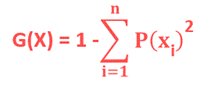   
We have to calculate the Gini-index concerning a given split and Information Gain. We split the feature with the lowest Gini-Index
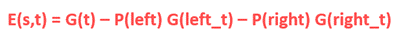

### <font color=blue>2. Training Decision Tree with default parameters

In [95]:
# import model
from sklearn.tree import DecisionTreeClassifier

# initiate model
tree_model = DecisionTreeClassifier()

# train model
tree_model.fit(X_train, y_train)

# view default paramenters
tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

### <font color=blue>3. Performance on Train set vs. Test set

In [96]:
y_train_pred = tree_model.predict(X_train)
prob_train_pred = tree_model.predict_proba(X_train)
y_test_pred = tree_model.predict(X_test)
prob_test_pred = tree_model.predict_proba(X_test)

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob=prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob=prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3610
           1       1.00      1.00      1.00       390

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          390     0
0            0  3610

Model Performance metrics:
------------------------------
Accuracy: 0.98
Precision: 0.9808
Recall: 0.98
F1 Score: 0.9803
ROC-AUC: 0.954

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       910
           1       0.86      0.92 

=> By default, Decision-Tree often has over-fitting problem: the result on the train set is very high (ROC-AUC=1) while the result on the test set is poorer (ROC-AUC=0.95). Every split is made at each node is optimized for the dataset it is fit to => this splitting process will rarely generalize well to other data. This is because the resulting tree might be too complex, the tree just follows data rather than learning the general pattern. 

### <font color=blue> 4. Tuning hyper-parameters
    
To avoid overfitting, a common approach is to restrict Decision Tree's freedom by setting hypeparameters such as max_depth, min_samples_leaf, mean_sample_split to restrict the shape of Decision Tree

1. **Hyper-parameters**: Hyperparameters are the knobs and controls we set with an aim to optimize the model’s performance on unseen data. These hyperparameters are different from parameters which are learned by our learning algorithm over the course of training process. Hyperparameters help us achieve objectives of avoiding overfitting and so on. Decision trees provide us with quite a few hyperparameters to play with 
    + min_samples_split: the minimum number of samples a node must have before it can be split
    + min_samples_leaf: the minimum number of samples a leaf node must have
    + min_weight_fraction_leaf: same as min_samples_leaf but expressed as a fraction of the total number of weighted instances
    + max_leaf_nodes: maximum number of leaf nodes
    + max_features: maximum number of features that are evaluated for splitting at each node
    + increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model

    
2. **Grid search**: The actual training process for decistion tree involves using k-fold cross validation to tune hyperparameters. Grid search is one of the popular methods for this task. It is a systematic approach where all combinations of parameters are tried to find the best combination. It is important to understand that grid search with cross validation was optimizing on finding the best set of hyperparmeters that can  help prepare a generalizable Decision Tree Regressor. 
    + Hyper-parameters are defined using a dictionary. The dictionary basically provides a list of feasible values for each of the hyperparmeters that we want to fine-tune.
    + sklearn provides a utility to grid search of the hyperparameters  with k-fold cross validation is an iterative process wrapped, optimized and standardized by GridSearchCV() function from model_selection module

In [97]:
params = {
    "criterion": ["gini"],
    "max_depth": [6,8],
    "min_samples_leaf": [30,50,80],
    "max_features": [7,9],
}
grid_search = GridSearchCV(DecisionTreeClassifier(), params)
grid_search.fit(X_train, y_train)

# tree best estimator
tree_model = grid_search.best_estimator_
# best model parameters
tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 9,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 30,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

#### View the hyperparameters and detailed information for the model

In [98]:
# view best score
print('Accuracy:{}'.format(grid_search.best_score_))
# View best hyperparameters
print('Best hyperparameters::\n{}'.format(grid_search.best_params_))
# View detailed information of each iteration
gridsearch_df = pd.DataFrame(grid_search.cv_results_)
gridsearch_df.head()

Accuracy:0.9792499999999998
Best hyperparameters::
{'criterion': 'gini', 'max_depth': 6, 'max_features': 9, 'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00634,0.00777,0.00000,0.00000,gini,6,7,30,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.97875,0.96250,0.97875,0.98500,0.95000,0.97100,0.01288,4
1,0.00626,0.00767,0.00000,0.00000,gini,6,7,50,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.96500,0.95500,0.97125,0.96375,0.95875,0.96275,0.00556,9
2,0.00000,0.00000,0.00000,0.00000,gini,6,7,80,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.96500,0.92000,0.97250,0.95375,0.96000,0.95425,0.01819,11
3,0.00625,0.00766,0.00000,0.00000,gini,6,9,30,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.97875,0.98375,0.98125,0.98250,0.97000,0.97925,0.00491,1
4,0.00000,0.00000,0.00313,0.00625,gini,6,9,50,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.97375,0.94375,0.97500,0.98250,0.97125,0.96925,0.01329,6


### <font color=blue> 5. Result

####  Visualize Decision Tree 

### <font color=blue>6. Important Features

In [99]:
tree_model.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 3.42852079e-01, 1.59396081e-01,
       4.73680125e-02, 4.49983634e-01, 4.00192996e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

Text(0.5, 1.0, 'Feature Importances for Decision Tree')

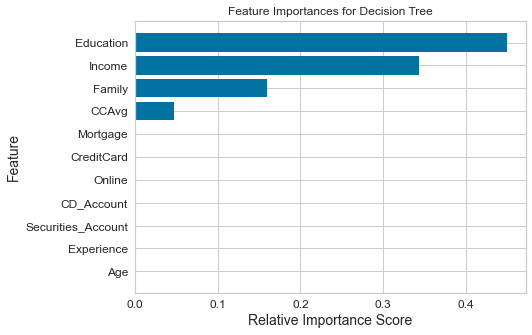

In [100]:
feature_importances = tree_model.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(TRAIN_VARS, feature_importances), key=lambda x: x[1]))
y_position = list(range(len(feature_names)))
plt.figure(figsize=(7,5))
plt.barh(y_position, feature_scores, height=0.8, align='center')
plt.yticks(y_position, feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances for Decision Tree')

### <font color=blue>7. Prediction

In [101]:
y_train_pred = tree_model.predict(X_train)
prob_train_pred = tree_model.predict_proba(X_train)

y_test_pred = tree_model.predict(X_test)
prob_test_pred = tree_model.predict_proba(X_test)

### <font color=blue>8.  Model Evaluation

#### Train data

In [102]:
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.9832
Precision: 0.9832
Recall: 0.9832
F1 Score: 0.9832
ROC-AUC: 0.9968

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3610
           1       0.92      0.91      0.91       390

    accuracy                           0.98      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.98      0.98      0.98      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          356    34
0           33  3577


#### Test data

In [103]:
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.982
Precision: 0.9817
Recall: 0.982
F1 Score: 0.9818
ROC-AUC: 0.9962

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       910
           1       0.92      0.88      0.90        90

    accuracy                           0.98      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.98      0.98      0.98      1000


Prediction Confusion Matrix:
------------------------------
Predicted   1    0
Actual            
1          79   11
0           7  903


=> THe model now is more general, the accuracy of the train set and test set is quite similar although the performance on test set is a bit lower than on training set

#### Perform 10-fold cross-validation for logistic Regression

In [104]:
kfold = KFold(n_splits=5)

# accuracy
scores = cross_val_score(tree_model, X_train, y_train, cv=kfold, scoring='roc_auc')
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()))
pd.Series(scores).describe()

Accuracy: 99.40% (+/- 0.26%)


count   5.00000
mean    0.99404
std     0.00295
min     0.99001
25%     0.99298
50%     0.99336
75%     0.99656
max     0.99729
dtype: float64

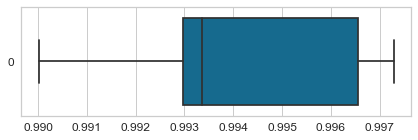

In [105]:
plt.figure(figsize=(7,2))
sns.boxplot(data=scores, orient='h')
plt.show()

---
---

## <font color=red>4.4. Random Forest

### <font color=blue>1. Overview
    
1. **Idea**: Random forests are an example of an ensemble method, meaning that it combine multiple machine learning algorithms and use the aggregation predictions to obtain better predictive performance. Random forest supports sample both data and features. More specifically, the Random Forest algorithm introduces extra randomness when growing trees instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.
    
    
2. **Algorithm**: 
    + ***Sampling dataset***: We use bootstrap technique to generate different bootstrapped training sets (select data from the original dataset with replacement)
    + ***Build a Decision Tree with each new sample***: But when building these decision trees, each time a split in a tree is considered, choose a random sample of m attributes as split candidates from the full set of p attributes (The split is allowed to use only one of those m attributes). A fresh sample of m attributes is taken at each split. The number of predictors considered at each split is approximately equal to the square root of the total number of predictors (m ≈ sqrt(p))
    + ***Prediction***: Once all predictors are trained, the ensemble can make a prediction for a new instance by simply chosing the major votes in the leaf

### <font color=blue>2. Train model

In [107]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier()

# Train model with default parameters
rf_model.fit(X_train, y_train)

# default parameters
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### <font color=blue>3. Model Performance

In [108]:
y_train_pred = rf_model.predict(X_train)
prob_train_pred = rf_model.predict_proba(X_train)

y_test_pred = rf_model.predict(X_test)
prob_test_pred = rf_model.predict_proba(X_test)

print('Train set')
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob=prob_train_pred[:,1])
print('Test set')
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob=prob_test_pred[:,1])

Train set
Model Performance metrics:
------------------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3610
           1       1.00      1.00      1.00       390

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          390     0
0            0  3610
Test set
Model Performance metrics:
------------------------------
Accuracy: 0.988
Precision: 0.9878
Recall: 0.988
F1 Score: 0.9878
ROC-AUC: 0.9958

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       910
           1 

### <font color=blue>4. Tuning hyper-parameters - GridSearchCV

In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [5,8],
    'max_features': ['auto', None, 'sqrt', 'log2', 5, 8],
    'min_samples_leaf': [30, 50, 100],
    'min_samples_split': [100, 200],
    'n_estimators': [100, 200],
}

# Create a base model
rf = RandomForestClassifier()
# Instantiate the gridsearch model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, m

[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=5, m

[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootst

[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_f

[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_featu

[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_featu

[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, m

[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_featu

[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_featu

[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, m

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  8.3min finished


#### View the hyperparameters and detailed information for the model

In [110]:
# View detailed informatino of each iteration of GridSearchCV()
gridsearch_df = pd.DataFrame(grid_search.cv_results_)
gridsearch_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.19402,0.01228,0.01071,0.00130,True,5,auto,30,100,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.99730,0.98722,0.99048,0.99460,0.99609,0.99616,0.99602,0.99687,0.99141,0.99545,0.99416,0.00316,38
1,0.44155,0.05068,0.02064,0.00460,True,5,auto,30,100,200,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.99680,0.98871,0.98935,0.99212,0.99737,0.99503,0.99702,0.99744,0.99474,0.99439,0.99430,0.00307,35
2,0.21463,0.02533,0.01146,0.00232,True,5,auto,30,200,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.99560,0.98686,0.98977,0.99460,0.99709,0.99638,0.99574,0.99794,0.99396,0.99155,0.99395,0.00334,44
3,0.38520,0.03168,0.02051,0.00361,True,5,auto,30,200,200,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.99645,0.98778,0.99020,0.98963,0.99730,0.99680,0.99517,0.99766,0.99453,0.99460,0.99401,0.00335,42
4,0.18487,0.00542,0.00988,0.00052,True,5,auto,50,100,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.99517,0.98281,0.98629,0.99077,0.99709,0.99354,0.99680,0.99553,0.99162,0.99496,0.99246,0.00446,88


In [111]:
# view best score
print('Accuracy:{}'.format(grid_search.best_score_))
# View best hyperparameters
print('Best hyperparameters::\n{}'.format(grid_search.best_params_))

Accuracy:0.9964308544640955
Best hyperparameters::
{'bootstrap': True, 'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 30, 'min_samples_split': 100, 'n_estimators': 100}


#### Retrain model with best hyper parameters

In [112]:
rf_model = grid_search.best_estimator_
# rf_model = RandomForestClassifier(bootstrap=True, max_depth=6, max_features=15, min_samples_leaf=100, min_samples_split=200, n_estimators=100)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 8,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 30,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [113]:
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
prob_train_pred = rf_model.predict_proba(X_train)

y_test_pred = rf_model.predict(X_test)
prob_test_pred = rf_model.predict_proba(X_test)

print('Train set:')
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob=prob_train_pred[:,1])
print('Test set:')
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob=prob_test_pred[:,1])

Train set:
Model Performance metrics:
------------------------------
Accuracy: 0.983
Precision: 0.9828
Recall: 0.983
F1 Score: 0.9826
ROC-AUC: 0.9972

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3610
           1       0.96      0.86      0.91       390

    accuracy                           0.98      4000
   macro avg       0.97      0.93      0.95      4000
weighted avg       0.98      0.98      0.98      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          335    55
0           13  3597
Test set:
Model Performance metrics:
------------------------------
Accuracy: 0.983
Precision: 0.9827
Recall: 0.983
F1 Score: 0.9827
ROC-AUC: 0.9964

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       91

### <font color=blue>5. Model Interpretation - Important features

<Axes: >

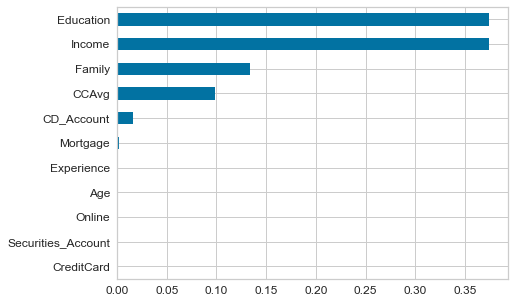

In [114]:
feature_importance = pd.Series(rf_model.feature_importances_, index=TRAIN_VARS)
feature_importance.sort_values(inplace=True, ascending=True)
feature_importance.plot.barh(figsize=(7,5))

---
## <font color=red>4.5. Gradient Boosting

### <font color=blue>1. Overview

### <font color=blue>2. Train model with default parameters

In [131]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize model
gb_model = GradientBoostingClassifier()

# Train model with default parameters
gb_model.fit(X_train, y_train)

# default parameters
gb_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### <font color=blue>3. Model Evaluation

In [132]:
y_train_pred = gb_model.predict(X_train)
prob_train_pred = gb_model.predict_proba(X_train)

y_test_pred = gb_model.predict(X_test)
prob_test_pred = gb_model.predict_proba(X_test)

print('Model Evaluation for Train test')
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob=prob_train_pred[:,1])
print('Model Evaluation for Test set')
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob=prob_test_pred[:,1])

Model Evaluation for Train test
Model Performance metrics:
------------------------------
Accuracy: 0.994
Precision: 0.994
Recall: 0.994
F1 Score: 0.9939
ROC-AUC: 0.9998

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3610
           1       0.99      0.95      0.97       390

    accuracy                           0.99      4000
   macro avg       0.99      0.97      0.98      4000
weighted avg       0.99      0.99      0.99      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          369    21
0            3  3607
Model Evaluation for Test set
Model Performance metrics:
------------------------------
Accuracy: 0.988
Precision: 0.9878
Recall: 0.988
F1 Score: 0.9879
ROC-AUC: 0.9984

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0

### <font color=blue> 4. Tuning hyper-parameters with GridSearchCV

#### Perform GridSearchCV

In [133]:
# Define parameters for grid search
param_grid = {
    'max_depth': [5,8],
    'max_features': ['auto', None, 'sqrt', 'log2', 5, 8],
    'min_samples_leaf': [50, 100, 200],
    'min_samples_split': [100,200],
}

# Initialize base model
gb = GradientBoostingClassifier()
# Initialize GridSearch
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=10, scoring='roc_auc', verbose=2)
# Perform grid search
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] max_depth=5, m

[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=200, total=   0.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=200, total=   0.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=200, total=   0.4s
[CV] max

[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.4s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.4s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.4s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.4s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.4s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.4s
[CV] max

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.2s
[CV] max_

[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=200, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=200, total=   0.2s
[CV] max_depth=5, m

[CV]  max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max

[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.3s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.2s
[CV] max_depth=5, max_features=5, min_sam

[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.4s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.4s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=5, max_features=8, min_sam

[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.5s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.5s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.5s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.5s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.5s
[CV] max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] max_depth=8,

[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] max_depth=8, m

[CV]  max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=100, total=   0.4s
[CV] max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=100, total=   0.4s
[CV] max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=100, total=   0.5s
[CV] max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=200, total=   0.8s
[CV] max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=200, total=   0.6s
[CV] max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=None, min_samples_leaf=200, min_samples_split=200, total=   0.6s
[CV] max

[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, total=   0.2s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, total=   0.2s
[CV] max

[CV]  max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.3s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.4s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.3s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.3s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.4s
[CV] max_

[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.4s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.4s
[CV] max_depth=8, max_features=5, min_samples_leaf=5

[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=200, total=   0.3s
[CV] max_depth=8, max_features=8, min_sam

[CV]  max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100, total=   0.3s
[CV] max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100, total=   0.3s
[CV] max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100, total=   0.4s
[CV] max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100, total=   0.4s
[CV] max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100, total=   0.3s
[CV] max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=200, min_samples_split=100, total=   0.3s
[CV] max_depth=8, max_features=8, min_sam

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  4.2min finished


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [5, 8],
                         'max_features': ['auto', None, 'sqrt', 'log2', 5, 8],
                         'min_samples_leaf': [50, 100, 200],
                         'min_samples_split': [100, 200]},
             scoring='roc_auc', verbose=2)

#### View grid search results

In [139]:
results = grid_search.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean,4), round(score_sd,4))

{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 100} 0.9981 0.001
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 200} 0.9979 0.0011
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 100, 'min_samples_split': 100} 0.9978 0.001
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 100, 'min_samples_split': 200} 0.9978 0.001
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 200, 'min_samples_split': 100} 0.9975 0.0013
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 200, 'min_samples_split': 200} 0.9975 0.0013
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 50, 'min_samples_split': 100} 0.998 0.001
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 50, 'min_samples_split': 200} 0.9979 0.0011
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 100, 'min_samples_split': 100} 0.9978 0.001
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 100

In [140]:
# Find gb model with best parameters
gb_model = grid_search.best_estimator_
gb_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Retrain model with best hyper parameters

In [142]:
gb_model.fit(X_train, y_train)

y_train_pred = gb_model.predict(X_train)
prob_train_pred = gb_model.predict_proba(X_train)

y_test_pred = gb_model.predict(X_test)
prob_test_pred = gb_model.predict_proba(X_test)

print('Train set: ')
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob=prob_train_pred[:,1])
print('Test set: ')
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob=prob_test_pred[:,1])

Train set: 
Model Performance metrics:
------------------------------
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9997
ROC-AUC: 1.0

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3610
           1       1.00      1.00      1.00       390

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          389     1
0            0  3610
Test set: 
Model Performance metrics:
------------------------------
Accuracy: 0.991
Precision: 0.9909
Recall: 0.991
F1 Score: 0.9909
ROC-AUC: 0.9982

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       9

### <font color=blue>5. Model Interpretation - Important features

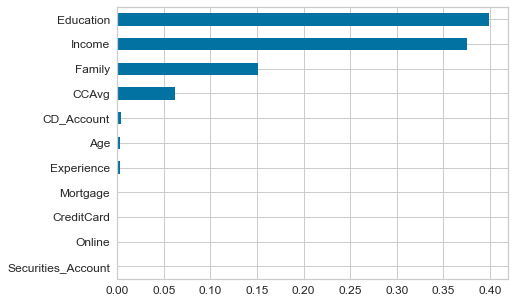

In [145]:
feature_importance = pd.Series(gb_model.feature_importances_, index=TRAIN_VARS)
feature_importance.sort_values(inplace=True, ascending=True)
feature_importance.plot.barh(figsize=(7,5))
plt.show()

---

## <font color=red>4.6. XGBoost

### <font color=blue>1. Overview

In [146]:
import time
import xgboost as xgb
import gc
#!pip install bayesian-optimization
#!pip install bayesian-optimization --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org --user
from bayes_opt import BayesianOptimization

### <font color=blue>2. Train model with default parameters

In [147]:
# start training
start_time = time.time()

# Initialize model
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# train model with default parameters
xgb_model.fit(X_train, y_train)

# Measure time
end_time = time.time()
time_cost = end_time - start_time
print('time cost is: ', time_cost)

# default parameters
xgb_model.get_params()

time cost is:  0.07805299758911133


{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### <font color=blue>3. Performance on Train set vs. Test set

#### Overall performance metric scores

In [148]:
y_train_pred = xgb_model.predict(X_train)
prob_train_pred = xgb_model.predict_proba(X_train)

y_test_pred = xgb_model.predict(X_test)
prob_test_pred = xgb_model.predict_proba(X_test)

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3610
           1       1.00      1.00      1.00       390

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          390     0
0            0  3610

Model Performance metrics:
------------------------------
Accuracy: 0.987
Precision: 0.9868
Recall: 0.987
F1 Score: 0.9868
ROC-AUC: 0.9977

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       910
           1       0.95      0.

In [149]:
print('total actual y:', y_test.sum())
print('total predicted y:', y_test_pred.sum())
print('total records in test set:', len(X_test))

total actual y: 90
total predicted y: 85
total records in test set: 1000


### <font color=blue> 4. Tuning hyper-parameters with BayesianOptimization

#### Perform GridSearchCV

In [155]:
# Define parameters for grid search
param_grid = {
    'max_depth': [5,8],
    'max_features': ['auto', None, 'sqrt', 'log2', 5, 8],
    'min_samples_leaf': [50,100,200],
    'min_samples_split': [100,200],
}
                          
# Initialize base model
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
# Initialize GridSearch
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='roc_auc', verbose=2)
# Perform grid search
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features

[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, m

[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_

[CV]  max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_featu

[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, m

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_de

[CV]  max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_fea

[CV]  max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max

[CV] max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=30, min_samples_split=50, 

[CV]  max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=5

[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=5, max_features=5, min_samples_leaf=200,

[CV]  max_depth=5, max_features=8, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=5, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=50, min_sam

[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=5, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=5, max_features=8, min_sam

[CV]  max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_feat

[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, m

[CV]  max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max

[CV]  max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_feature

[CV]  max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=None, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max

[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features

[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, m

[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_

[CV]  max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_fea

[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max

[CV]  max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50 
[CV]  max_depth=8, max_features=5, min_samples_leaf=30, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=30, min_samp

[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200 
[CV]  max_depth=8, max_features=5, min_samples_leaf=50, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=5

[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100 
[CV]  max_depth=8, max_features=5, min_samples_leaf=200, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=5, min_samp

[CV]  max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200 
[CV]  max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200 
[CV]  max_depth=8, max_features=8, min_samples_leaf=30, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=50 
[CV]  max_depth=8, max_features=8, min_samples_leaf=50, min_samples_split=50, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=50, min

[CV]  max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.2s
[CV] max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100 
[CV]  max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=100, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=200 
[CV]  max_depth=8, max_features=8, min_samples_leaf=100, min_samples_split=200, total=   0.1s
[CV] max_depth=8, max_features=8, min_sam

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  2.5min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

#### View grid search results

In [156]:
results = grid_search.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean,4), round(score_sd,4))

{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 30, 'min_samples_split': 50} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 30, 'min_samples_split': 100} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 30, 'min_samples_split': 200} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 100} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 200} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 100, 'min_samples_split': 50} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 100, 'min_samples_split': 100} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 100, 'min_samples_split': 200} 0.9976 0.0014
{'max_depth': 5, 'max_features': 'auto', 'min_samples_l

In [157]:
# Find gb model with best parameters
xgb_model = grid_search.best_estimator_
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_s

#### Retrain model with best hyper parameters

In [158]:
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
prob_train_pred = xgb_model.predict_proba(X_train)

y_test_pred = xgb_model.predict(X_test)
prob_test_pred = xgb_model.predict_proba(X_test)

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3610
           1       1.00      1.00      1.00       390

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          390     0
0            0  3610

Model Performance metrics:
------------------------------
Accuracy: 0.989
Precision: 0.9889
Recall: 0.989
F1 Score: 0.9888
ROC-AUC: 0.9979

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       910
           1       0.98      0.

---
## <font color=red> 4.7. Gaussian Naive Bayes

### <font color=blue>1. Overview

1. Bayes Classifier applies Bayes' rule to calculate posterior probability of an object (data point) for each of class. These probabilities can then form the basis of a decision-making process such as assigning the object to the class with the highest probability

    
2. Gassian Naive Bayes' assumption:
    + Features come froms Gaussian distribution
    + Features are independent
    
    
3. Abstract Mathematical Approach
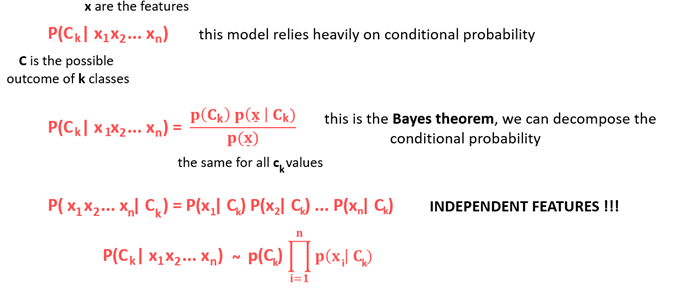

### <font color=blue>2. Train model

#### Select continuos vars

As Gaussian Naive Bayes assumes that the features follow Gaussian distribution, therefore the input features used to train the model should be continous vars

In [159]:
scaled_train.describe()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard
count,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000
mean,0.50710,0.46783,0.30552,0.46508,0.19478,0.43738,0.08700,0.10700,0.06075,0.59475,0.29350
std,0.26115,0.26644,0.21430,0.38375,0.17574,0.41795,0.15770,0.30915,0.23890,0.49100,0.45542
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.27273,0.23256,0.14352,0.00000,0.07000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.50000,0.46512,0.25926,0.33333,0.15000,0.50000,0.00000,0.00000,0.00000,1.00000,0.00000
75%,0.72727,0.69767,0.42130,0.66667,0.26000,1.00000,0.15433,0.00000,0.00000,1.00000,1.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [160]:
from sklearn.naive_bayes import GaussianNB

# Initiate model
gnb_model = GaussianNB()

# train model
gnb_model.fit(scaled_train[TRAIN_VARS], y_train)

GaussianNB()

### <font color=blue>3. Prediction

In [161]:
y_train_pred = gnb_model.predict(scaled_train[TRAIN_VARS])
prob_train_pred = gnb_model.predict_proba(scaled_train[TRAIN_VARS])

y_test_pred = gnb_model.predict(scaled_test[TRAIN_VARS])
prob_test_pred = gnb_model.predict_proba(scaled_test[TRAIN_VARS])

### <font color=blue>4. Model Evaluation

#### Performance metric in Train set and Test set

In [162]:
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.8828
Precision: 0.9011
Recall: 0.8828
F1 Score: 0.8905
ROC-AUC: 0.9275

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3610
           1       0.43      0.58      0.49       390

    accuracy                           0.88      4000
   macro avg       0.69      0.75      0.71      4000
weighted avg       0.90      0.88      0.89      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          225   165
0          304  3306

Model Performance metrics:
------------------------------
Accuracy: 0.892
Precision: 0.9121
Recall: 0.892
F1 Score: 0.9003
ROC-AUC: 0.9284

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       910
           1    

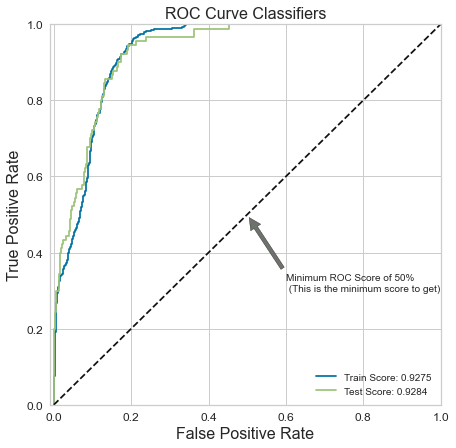

In [163]:
plot_roc_curve(y_train, prob_train_pred, y_test, prob_test_pred)

---
---
## <font color=red>4.8. Linear Discriminant Analysis - LDA

### <font color=blue>1. Overview

1. LDA is a Bayes classifier which means it applies Bayes' rule to calculate posterior probability of an object (data point) for each of potential classes. These probabilities can then form the basis of a decision-making process such as assigning the object to the class with the highest probability
    
    
2. However, unlike Naive Bayes, LDA assumes that there are relationships between dependent variables X and these relationships are the same for all classes. Hence, the random variable X is a vector X=(X1, X2,...,Xp) which is drawn from a multivariate Gaussian with class-specific mean vector and a common covariance matrix. In other words, the covariance matrix is common to all K classes. 

    
3. LDA formula to calculate posterior porbabiliy for each class
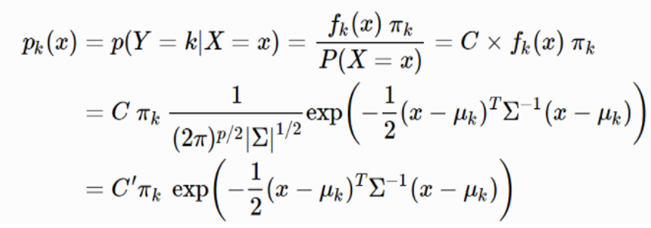

    
4. In practice, the objective function applies this formula

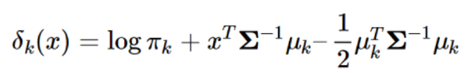

=> It is called linear discriminant function because it is linear in the sense that it has only a linear dependence on x

    
5. Note:
    + Since P(X) does not depend on k so we write it as a constant, all constant terms are put into C, C'
    
    
6. Parameters of multivariate Gaussian: the maximimum likelihood estimates the mean and covariance of a Gaussian
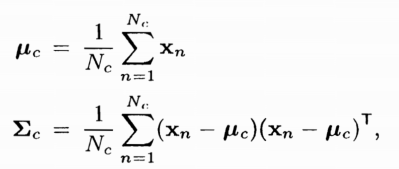

### <font color=blue> 2. Train model

#### Select contionuos vars

As LDA assumes that the features follow Gaussian distribution, therefore the input features used to train the model should be continous vars

In [164]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(scaled_train[TRAIN_VARS], y_train)

LinearDiscriminantAnalysis()

### <font color=blue>3. Prediction

In [165]:
y_train_pred = lda_model.predict(X_train[TRAIN_VARS])
prob_train_pred = lda_model.predict_proba(scaled_train[TRAIN_VARS])

y_test_pred = lda_model.predict(X_test[TRAIN_VARS])
prob_test_pred = lda_model.predict_proba(scaled_test[TRAIN_VARS])

### <font color=blue>4. Model Evaluation

#### Performance metric in Train set and Test set

In [166]:
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.099
Precision: 0.912
Recall: 0.099
F1 Score: 0.0203
ROC-AUC: 0.959

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3610
           1       0.10      1.00      0.18       390

    accuracy                           0.10      4000
   macro avg       0.55      0.50      0.09      4000
weighted avg       0.91      0.10      0.02      4000


Prediction Confusion Matrix:
------------------------------
Predicted     1  0
Actual            
1           390  0
0          3604  6

Model Performance metrics:
------------------------------
Accuracy: 0.091
Precision: 0.9181
Recall: 0.091
F1 Score: 0.0169
ROC-AUC: 0.9494

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       910
           1       0.09     

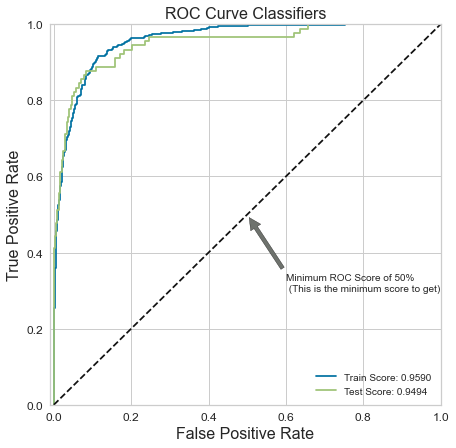

In [167]:
plot_roc_curve(y_train, prob_train_pred, y_test, prob_test_pred)

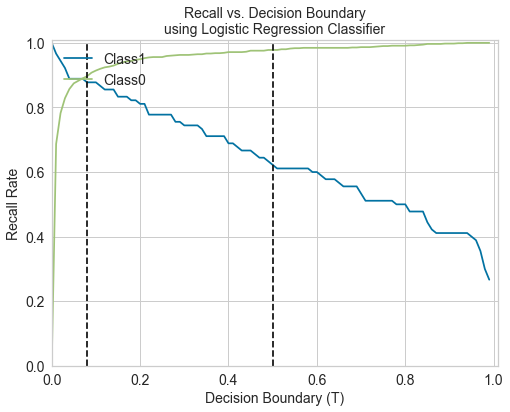

In [168]:
t_precision_0, t_precision_1, t_recall_0, t_recall_1 = precision_recall_threshold(prob_test_pred, y_test)
plot_recall_vs_decision_boundary(t_recall_1, t_recall_0, .08)

#### Select threshold = 0.1

In [169]:
tr = 0.08
y_train_pred = np.where(prob_train_pred[:,1] > tr, 1, 0)
y_test_pred = np.where(prob_test_pred[:,1] > tr,1 , 0)

prediction_df = pd.DataFrame()
prediction_df['True_Outcome'] = y_test
prediction_df['Prediction'] = y_test_pred
prediction_df['Probability'] = prob_test_pred[:,1]

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.8968
Precision: 0.9384
Recall: 0.8968
F1 Score: 0.9097
ROC-AUC: 0.959

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3610
           1       0.48      0.89      0.63       390

    accuracy                           0.90      4000
   macro avg       0.74      0.90      0.78      4000
weighted avg       0.94      0.90      0.91      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          349    41
0          372  3238

Model Performance metrics:
------------------------------
Accuracy: 0.895
Precision: 0.939
Recall: 0.895
F1 Score: 0.9091
ROC-AUC: 0.9494

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       910
           1      

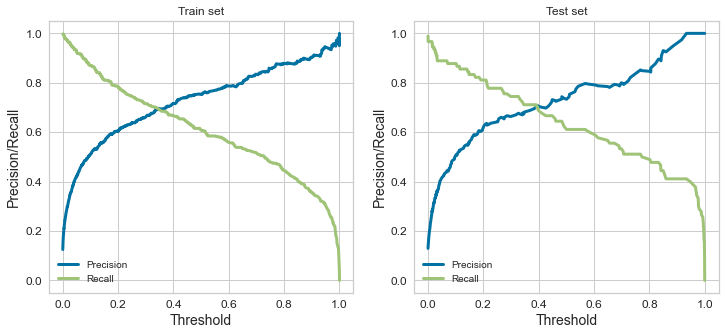

Model Performance metrics:
------------------------------
Accuracy: 0.938
Precision: 0.9393
Recall: 0.938
F1 Score: 0.9386
ROC-AUC: 0.959

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3610
           1       0.67      0.71      0.69       390

    accuracy                           0.94      4000
   macro avg       0.82      0.83      0.83      4000
weighted avg       0.94      0.94      0.94      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          275   115
0          133  3477

Model Performance metrics:
------------------------------
Accuracy: 0.944
Precision: 0.947
Recall: 0.944
F1 Score: 0.9453
ROC-AUC: 0.9494

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       910
           1       0

In [170]:
plt.figure(figsize=(12,5))
plt.subplot(121)
select_threshold(y_train, prob_train_pred[:,1])
plt.title('Train set')
plt.subplot(122)
select_threshold(y_test, prob_test_pred[:,1])
plt.title('Test set')
plt.show()

tr = 0.32
y_train_pred = np.where(prob_train_pred[:,1] > tr, 1, 0)
y_test_pred = np.where(prob_test_pred[:,1] > tr,1 , 0)

prediction_df = pd.DataFrame()
prediction_df['True_Outcome'] = y_test
prediction_df['Prediction'] = y_test_pred
prediction_df['Probability'] = prob_test_pred[:,1]

display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

---
## <font color=red> 4.9. QDA

### <font color=blue>1. Introduction

1. QDA is a Bayes classifier which means it applies Bayes' rule to calculate posterior probability of an object (data point) for each of potential classes. These probabilities can then form the basis of a decision-making process such as assigning the object to the class with the highest probability
    
2. QDA is similar to LDA except that QDA assumes individual covariance matrices different, then the discriminant function becomes, which is quadratic in x in the last term

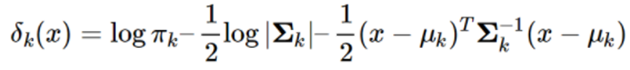

2. QDA requires many more parameters than LDA because of the multiple covariance matrices used. Although the extra flexibility may be useful, but the suggession is the simple model of LDA will suffice unless the covariance differenes between classes are significant

### <font color=blue> 2. Train model

In [171]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis(store_covariance=True)
qda_model.fit(scaled_train[TRAIN_VARS], y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

### <font color=blue> 3. Prediction

In [172]:
y_train_pred = qda_model.predict(X_train[TRAIN_VARS])
prob_train_pred = qda_model.predict_proba(scaled_train[TRAIN_VARS])

y_test_pred = qda_model.predict(X_test[TRAIN_VARS])
prob_test_pred = qda_model.predict_proba(scaled_test[TRAIN_VARS])

### <font color=blue>4. Model Evaluation

In [173]:
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.5722
Precision: 0.904
Recall: 0.5722
F1 Score: 0.6543
ROC-AUC: 0.9554

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.98      0.54      0.69      3610
           1       0.18      0.91      0.29       390

    accuracy                           0.57      4000
   macro avg       0.58      0.72      0.49      4000
weighted avg       0.90      0.57      0.65      4000


Prediction Confusion Matrix:
------------------------------
Predicted     1     0
Actual               
1           356    34
0          1677  1933

Model Performance metrics:
------------------------------
Accuracy: 0.576
Precision: 0.9141
Recall: 0.576
F1 Score: 0.6615
ROC-AUC: 0.9516

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       910
           1 

---
## <font color=red>4.10. KNN

### <font color=blue> 1. Overview
    
1. KNN classifier is a non-parametric model. It can classify examples by assigning them the class of the most similar labeled examples. KNN algorithm identifies k elements in the training dataset that are the “nearest” in similarity. The unlabeled test example is assigned to the class of the majority of the k nearest neighbors
    
    
2. KNN uses Euclidean to calculate between 2 data points
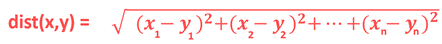
    
3. It is important to scale/normalize data in KNN algorithm. This is because if certain features have much larger values than others -> the distance measurements will be strongly dominated by the larger values. We have to rescale the various features such that each one contributes relatively equally to the distance formula

### <font color=blue>2. Training with default parameters

In [175]:
# Initialize model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)

# Train model
knn_model.fit(scaled_train, y_train)

# default parameters
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### <font color=blue>3. Select k values
    
Deciding how many neighbors to use for KNN -> determine how well the model will generalize and work on other datasets

In [176]:
error_rate = []
for i in range(1,50):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(scaled_train, y_train)
    pred_i = knn_model.predict(scaled_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

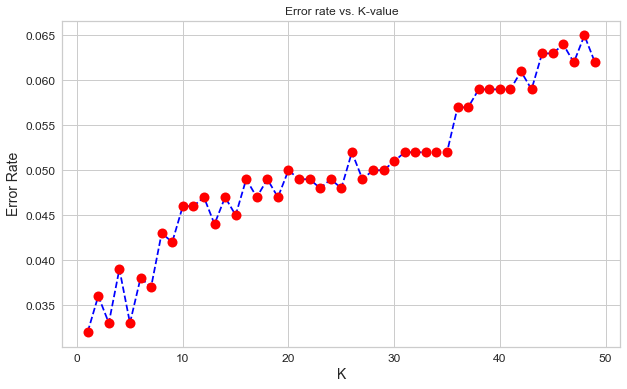

In [177]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,50), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error rate vs. K-value')
plt.xlabel('K')
plt.ylabel('Error Rate')

### <font color=blue> 4. Tuning hyper-parameter

In [178]:
params = {"n_neighbors": list(range(20,200,10)), 'algorithm':['auto','ball_tree','kd_tree','brute']}
grid_search = GridSearchCV(KNeighborsClassifier(), params)
grid_search.fit(scaled_train, y_train)

# KNears best estimator
knn_model = grid_search.best_estimator_
knn_model

KNeighborsClassifier(n_neighbors=20)

### <font color=blue>5.  Retrain with best model

In [179]:
knn_model = KNeighborsClassifier(n_neighbors=180)
knn_model.fit(scaled_train, y_train)

KNeighborsClassifier(n_neighbors=180)

### <font color=blue>6. Prediction

In [180]:
y_train_pred = knn_model.predict(X_train)
prob_train_pred = knn_model.predict_proba(X_train)

y_test_pred = knn_model.predict(X_test)
prob_test_pred = knn_model.predict_proba(X_test)

### <font color=blue>7. Performance with 10-fold cross validation

In [181]:
display_model_performance_metrics(true_labels=y_train, predicted_labels=y_train_pred, predicted_prob = prob_train_pred[:,1])
print()
display_model_performance_metrics(true_labels=y_test, predicted_labels=y_test_pred, predicted_prob = prob_test_pred[:,1])

Model Performance metrics:
------------------------------
Accuracy: 0.813
Precision: 0.8747
Recall: 0.813
F1 Score: 0.8378
ROC-AUC: 0.8038

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3610
           1       0.26      0.51      0.35       390

    accuracy                           0.81      4000
   macro avg       0.60      0.68      0.62      4000
weighted avg       0.87      0.81      0.84      4000


Prediction Confusion Matrix:
------------------------------
Predicted    1     0
Actual              
1          198   192
0          556  3054

Model Performance metrics:
------------------------------
Accuracy: 0.825
Precision: 0.8761
Recall: 0.825
F1 Score: 0.8466
ROC-AUC: 0.8049

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       910
           1      

Accuracy: 90.25% (+/- 0.00%)


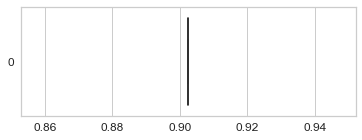

In [182]:
scores = cross_val_score(knn_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

plt.figure(figsize=(6,2))
sns.boxplot(data=scores, orient='h')
plt.show()

---
# <font color=red>4.11. DNN

### <font color=blue> Overview

 ### <font color=blue>**Construct Model**

In [183]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from keras.metrics import categorical_crossentropy

In [185]:
# refresh session for multiple run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = len(TRAIN_VARS)
dnn_model = Sequential()
dnn_model.add(Dense(8, activation='relu', input_shape=(n_inputs, )))
dnn_model.add(Dense(4, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))

print(dnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________
None


### <font color=blue> Train model

In [186]:
# Compiling model
dnn_model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
history = dnn_model.fit(X_train, y_train, validation_split=0.2, batch_size=5, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
640/640 - 2s - loss: 1.3067 - accuracy: 0.8572 - val_loss: 0.4694 - val_accuracy: 0.7600 - 2s/epoch - 2ms/step
Epoch 2/20
640/640 - 1s - loss: 0.3330 - accuracy: 0.8681 - val_loss: 0.3262 - val_accuracy: 0.8913 - 880ms/epoch - 1ms/step
Epoch 3/20
640/640 - 1s - loss: 0.2851 - accuracy: 0.8847 - val_loss: 0.2601 - val_accuracy: 0.9050 - 752ms/epoch - 1ms/step
Epoch 4/20
640/640 - 1s - loss: 0.2531 - accuracy: 0.8934 - val_loss: 0.2398 - val_accuracy: 0.9075 - 752ms/epoch - 1ms/step
Epoch 5/20
640/640 - 1s - loss: 0.2430 - accuracy: 0.8988 - val_loss: 0.2220 - val_accuracy: 0.9112 - 713ms/epoch - 1ms/step
Epoch 6/20
640/640 - 1s - loss: 0.2355 - accuracy: 0.9034 - val_loss: 0.2471 - val_accuracy: 0.9075 - 940ms/epoch - 1ms/step
Epoch 7/20
640/640 - 1s - loss: 0.2142 - accuracy: 0.9056 - val_loss: 0.2162 - val_accuracy: 0.9187 - 933ms/epoch - 1ms/step
Epoch 8/20
640/640 - 1s - loss: 0.2107 - accuracy: 0.9106 - val_loss: 0.2393 - val_accuracy: 0.9137 - 888ms/epoch - 1ms/step
Epo

 ### <font color=blue>**Plot loss history**

In [187]:
print(history.params)
print(history.epoch)
print(history.history.keys())

{'verbose': 2, 'epochs': 20, 'steps': 640}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


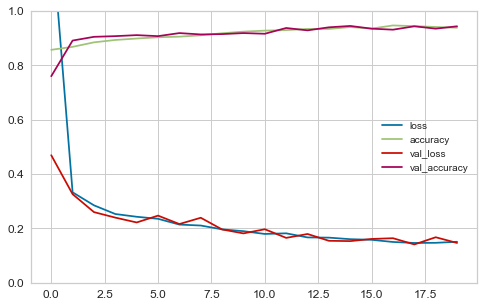

In [188]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### <font color=blue> 3. Prediction

In [189]:
y_train_pred = dnn_model.predict(scaled_train)
y_test_pred = dnn_model.predict(scaled_test)

y_train_pred[0:5]

array([[0.01845258],
       [0.03418809],
       [0.03047407],
       [0.04709893],
       [0.05089596]], dtype=float32)

### <font color=blue> 4. Model Evaluation

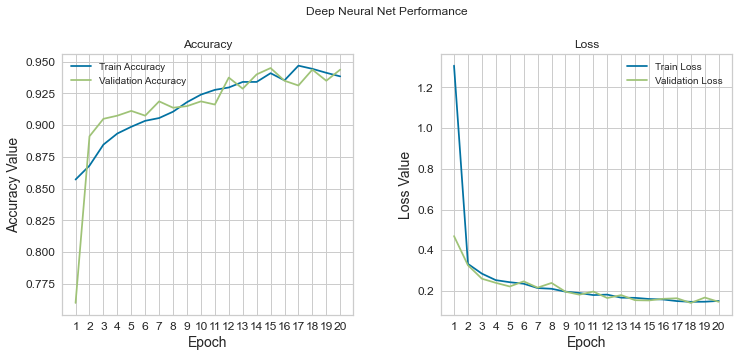

In [190]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,21))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### <font color=blue> 5. Tuning hyper-parameters

In [191]:
# Do a grid search for the optimal batch size and number of epochs
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# refresh session for multiple run
keras.backend.clear_session()
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed)


# Defining model
def create_model():
    model = Sequential()
    model.add(Dense(n_inputs, input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn = create_model, verbose=1)

# define the grid search parameters
batch_size = [10, 20, 40]
epochs = [10, 50, 100]

# make a dictionary of the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(random_state=seed), verbose=10)
grid_results = grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] batch_size=10, epochs=10 ........................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


320/320 [==============================] - 1s 1ms/step - loss: 0.3211 - accuracy: 0.9000
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2341 - accuracy: 0.9000
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2147 - accuracy: 0.9000
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2045 - accuracy: 0.9000
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1977 - accuracy: 0.9000
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1896 - accuracy: 0.9000
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.9000
Epoch 8/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1842 - accuracy: 0.9000
Epoch 9/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1752 - accuracy: 0.9000
Epoch 10/10
80/80 [==============================] - 0s 1ms/step - loss: 0.1735 - accuracy: 0.9125
[CV] .......

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


320/320 [==============================] - 1s 2ms/step - loss: 0.3462 - accuracy: 0.8947
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 0.2552 - accuracy: 0.9066
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2321 - accuracy: 0.9066
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2203 - accuracy: 0.9066
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.2079 - accuracy: 0.9066
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1991 - accuracy: 0.9066
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1914 - accuracy: 0.9066
Epoch 8/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1802 - accuracy: 0.9066
Epoch 9/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1721 - accuracy: 0.9066
Epoch 10/10
80/80 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 0.8863
[CV] .......

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.4222 - accuracy: 0.8963
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 0.2747 - accuracy: 0.9013
Epoch 3/10
320/320 [==============================] - 0s 2ms/step - loss: 0.2437 - accuracy: 0.9013
Epoch 4/10
320/320 [==============================] - 0s 2ms/step - loss: 0.2297 - accuracy: 0.9013
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2184 - accuracy: 0.9013
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2089 - accuracy: 0.9013
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2018 - accuracy: 0.9013
Epoch 8/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1953 - accuracy: 0.9013
Epoch 9/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.9013
Epoch 10/10
80/80 [==============================] - 0s 1ms/step - loss: 0.1700 - accuracy: 0.9075
[CV] .......

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.3550 - accuracy: 0.9028
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2515 - accuracy: 0.9028
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2299 - accuracy: 0.9028
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2168 - accuracy: 0.9028
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2075 - accuracy: 0.9028
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1992 - accuracy: 0.9028
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1935 - accuracy: 0.9028
Epoch 8/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1897 - accuracy: 0.9028
Epoch 9/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1797 - accuracy: 0.9109
Epoch 10/10
80/80 [==============================] - 0s 1ms/step - loss: 0.1588 - accuracy: 0.9550
[CV] .......

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.4s remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.3244 - accuracy: 0.9019
Epoch 2/10
320/320 [==============================] - 0s 2ms/step - loss: 0.2465 - accuracy: 0.9019
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2275 - accuracy: 0.9019
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2144 - accuracy: 0.9019
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2020 - accuracy: 0.9019
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1989 - accuracy: 0.9019
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1854 - accuracy: 0.9019
Epoch 8/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1799 - accuracy: 0.9019
Epoch 9/10
320/320 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9019
Epoch 10/10
80/80 [==============================] - 0s 1ms/step - loss: 0.1557 - accuracy: 0.9050
[CV] .......

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.6s remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.3207 - accuracy: 0.8997
Epoch 2/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2330 - accuracy: 0.8963
Epoch 3/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2128 - accuracy: 0.8988
Epoch 4/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2030 - accuracy: 0.9034
Epoch 5/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1962 - accuracy: 0.9038
Epoch 6/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1876 - accuracy: 0.9041
Epoch 7/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.9047
Epoch 8/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1781 - accuracy: 0.9112
Epoch 9/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1710 - accuracy: 0.9156
Epoch 10/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1633 - accuracy: 0.9219
Epoch 11/5

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   49.2s remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.4451 - accuracy: 0.9003
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2737 - accuracy: 0.9006
Epoch 3/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2395 - accuracy: 0.9028
Epoch 4/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2238 - accuracy: 0.9034
Epoch 5/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2100 - accuracy: 0.9081
Epoch 6/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1990 - accuracy: 0.9094
Epoch 7/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1901 - accuracy: 0.9141
Epoch 8/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1770 - accuracy: 0.9219
Epoch 9/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1696 - accuracy: 0.9216
Epoch 10/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1563 - accuracy: 0.9309
Epoch 11/5

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.3979 - accuracy: 0.8644
Epoch 2/50
320/320 [==============================] - 0s 2ms/step - loss: 0.2646 - accuracy: 0.9013
Epoch 3/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2361 - accuracy: 0.9013
Epoch 4/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2229 - accuracy: 0.9013
Epoch 5/50
320/320 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9013
Epoch 6/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2061 - accuracy: 0.9013
Epoch 7/50
320/320 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.9013
Epoch 8/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1984 - accuracy: 0.9013
Epoch 9/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1923 - accuracy: 0.9013
Epoch 10/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1930 - accuracy: 0.9013
Epoch 11/5

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.3277 - accuracy: 0.9022
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2326 - accuracy: 0.9028
Epoch 3/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.9028
Epoch 4/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.9028
Epoch 5/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1996 - accuracy: 0.9028
Epoch 6/50
320/320 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.9028
Epoch 7/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1871 - accuracy: 0.9028
Epoch 8/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1812 - accuracy: 0.9028
Epoch 9/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1722 - accuracy: 0.9116
Epoch 10/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1615 - accuracy: 0.9287
Epoch 11/5

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.4061 - accuracy: 0.8809
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2637 - accuracy: 0.9016
Epoch 3/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2346 - accuracy: 0.9019
Epoch 4/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2191 - accuracy: 0.9019
Epoch 5/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2065 - accuracy: 0.9019
Epoch 6/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2021 - accuracy: 0.9019
Epoch 7/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1948 - accuracy: 0.9019
Epoch 8/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1943 - accuracy: 0.9019
Epoch 9/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1916 - accuracy: 0.9019
Epoch 10/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1894 - accuracy: 0.9019
Epoch 11/5

320/320 [==============================] - 0s 904us/step - loss: 0.0879 - accuracy: 0.9700
Epoch 29/100
320/320 [==============================] - 0s 924us/step - loss: 0.0937 - accuracy: 0.9663
Epoch 30/100
320/320 [==============================] - 0s 953us/step - loss: 0.0851 - accuracy: 0.96880s - loss: 0.0830 - accuracy
Epoch 31/100
320/320 [==============================] - 0s 910us/step - loss: 0.0814 - accuracy: 0.9706
Epoch 32/100
320/320 [==============================] - 0s 941us/step - loss: 0.0798 - accuracy: 0.9709
Epoch 33/100
320/320 [==============================] - 0s 949us/step - loss: 0.0825 - accuracy: 0.9681
Epoch 34/100
320/320 [==============================] - 0s 933us/step - loss: 0.0815 - accuracy: 0.9719
Epoch 35/100
320/320 [==============================] - 0s 935us/step - loss: 0.0780 - accuracy: 0.9734
Epoch 36/100
320/320 [==============================] - 0s 881us/step - loss: 0.0813 - accuracy: 0.9675
Epoch 37/100
320/320 [===========================

320/320 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.9066
Epoch 6/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1850 - accuracy: 0.9066
Epoch 7/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1758 - accuracy: 0.9066
Epoch 8/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1656 - accuracy: 0.9066
Epoch 9/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1568 - accuracy: 0.9066
Epoch 10/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1504 - accuracy: 0.9066
Epoch 11/100
320/320 [==============================] - 0s 2ms/step - loss: 0.1518 - accuracy: 0.9350
Epoch 12/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1404 - accuracy: 0.9516
Epoch 13/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1419 - accuracy: 0.9456
Epoch 14/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1322 - accuracy: 0.95

320/320 [==============================] - 1s 2ms/step - loss: 0.0720 - accuracy: 0.9728
Epoch 86/100
320/320 [==============================] - 1s 2ms/step - loss: 0.0756 - accuracy: 0.9728
Epoch 87/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9762
Epoch 88/100
320/320 [==============================] - 1s 2ms/step - loss: 0.0730 - accuracy: 0.9722
Epoch 89/100
320/320 [==============================] - 1s 2ms/step - loss: 0.0759 - accuracy: 0.9722
Epoch 90/100
320/320 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9741
Epoch 91/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0755 - accuracy: 0.9734
Epoch 92/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0741 - accuracy: 0.9750
Epoch 93/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0719 - accuracy: 0.9741
Epoch 94/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0695 - accuracy: 

320/320 [==============================] - 0s 914us/step - loss: 0.0802 - accuracy: 0.9734
Epoch 63/100
320/320 [==============================] - 0s 911us/step - loss: 0.0815 - accuracy: 0.9703
Epoch 64/100
320/320 [==============================] - 0s 913us/step - loss: 0.0813 - accuracy: 0.9716
Epoch 65/100
320/320 [==============================] - 0s 925us/step - loss: 0.0835 - accuracy: 0.9706
Epoch 66/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9753
Epoch 67/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0961 - accuracy: 0.9663
Epoch 68/100
320/320 [==============================] - 0s 944us/step - loss: 0.0841 - accuracy: 0.9700
Epoch 69/100
320/320 [==============================] - 0s 943us/step - loss: 0.0797 - accuracy: 0.9694
Epoch 70/100
320/320 [==============================] - 0s 919us/step - loss: 0.0794 - accuracy: 0.9719
Epoch 71/100
320/320 [==============================] - 0s 1ms/step - loss: 0.077

320/320 [==============================] - 0s 944us/step - loss: 0.1205 - accuracy: 0.9581
Epoch 40/100
320/320 [==============================] - 0s 910us/step - loss: 0.1182 - accuracy: 0.9594
Epoch 41/100
320/320 [==============================] - 0s 896us/step - loss: 0.1146 - accuracy: 0.9588
Epoch 42/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1185 - accuracy: 0.9588
Epoch 43/100
320/320 [==============================] - 0s 893us/step - loss: 0.1128 - accuracy: 0.9606
Epoch 44/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1139 - accuracy: 0.9581
Epoch 45/100
320/320 [==============================] - 0s 975us/step - loss: 0.1082 - accuracy: 0.9616
Epoch 46/100
320/320 [==============================] - 0s 940us/step - loss: 0.1062 - accuracy: 0.9600
Epoch 47/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1149 - accuracy: 0.9566
Epoch 48/100
320/320 [==============================] - 0s 903us/step - loss: 0.104

320/320 [==============================] - 0s 1ms/step - loss: 0.1030 - accuracy: 0.9644
Epoch 18/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1002 - accuracy: 0.9631
Epoch 19/100
320/320 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.9625
Epoch 20/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1000 - accuracy: 0.9663
Epoch 21/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9666
Epoch 22/100
320/320 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9663
Epoch 23/100
320/320 [==============================] - 0s 2ms/step - loss: 0.0941 - accuracy: 0.9641
Epoch 24/100
320/320 [==============================] - 1s 2ms/step - loss: 0.0995 - accuracy: 0.9619
Epoch 25/100
320/320 [==============================] - 1s 2ms/step - loss: 0.0900 - accuracy: 0.9684
Epoch 26/100
320/320 [==============================] - 1s 2ms/step - loss: 0.0873 - accuracy: 

320/320 [==============================] - 1s 2ms/step - loss: 0.0688 - accuracy: 0.9762
Epoch 98/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0674 - accuracy: 0.9753
Epoch 99/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.9794
Epoch 100/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0825 - accuracy: 0.9650
[CV] ........... batch_size=10, epochs=100, score=0.965, total=  47.3s
[CV] batch_size=20, epochs=10 ........................................
Epoch 1/10
160/160 [==============================] - 0s 1ms/step - loss: 0.4217 - accuracy: 0.8897
Epoch 2/10
160/160 [==============================] - 0s 1ms/step - loss: 0.2642 - accuracy: 0.9000
Epoch 3/10
160/160 [==============================] - 0s 1ms/step - loss: 0.2418 - accuracy: 0.9000
Epoch 4/10
160/160 [==============================] - 0s 1ms/step - loss: 0.2180 - accuracy: 0.9000
Epoch 5/10
160/160 [==============================] - 0s 1ms/ste

160/160 [==============================] - 0s 943us/step - loss: 0.1837 - accuracy: 0.9000
Epoch 15/50
160/160 [==============================] - 0s 944us/step - loss: 0.1829 - accuracy: 0.9000
Epoch 16/50
160/160 [==============================] - 0s 918us/step - loss: 0.1789 - accuracy: 0.9000
Epoch 17/50
160/160 [==============================] - 0s 900us/step - loss: 0.1775 - accuracy: 0.9000
Epoch 18/50
160/160 [==============================] - 0s 905us/step - loss: 0.1725 - accuracy: 0.9000
Epoch 19/50
160/160 [==============================] - 0s 923us/step - loss: 0.1676 - accuracy: 0.9000
Epoch 20/50
160/160 [==============================] - 0s 901us/step - loss: 0.1671 - accuracy: 0.9000
Epoch 21/50
160/160 [==============================] - 0s 907us/step - loss: 0.1678 - accuracy: 0.9000
Epoch 22/50
160/160 [==============================] - 0s 877us/step - loss: 0.1602 - accuracy: 0.9000
Epoch 23/50
160/160 [==============================] - 0s 930us/step - loss: 0.1596 -

160/160 [==============================] - 0s 900us/step - loss: 0.1035 - accuracy: 0.9634
Epoch 42/50
160/160 [==============================] - 0s 952us/step - loss: 0.0950 - accuracy: 0.9684
Epoch 43/50
160/160 [==============================] - 0s 923us/step - loss: 0.1000 - accuracy: 0.9650
Epoch 44/50
160/160 [==============================] - 0s 929us/step - loss: 0.0949 - accuracy: 0.9691
Epoch 45/50
160/160 [==============================] - 0s 1ms/step - loss: 0.0886 - accuracy: 0.9712
Epoch 46/50
160/160 [==============================] - 0s 893us/step - loss: 0.0875 - accuracy: 0.9712
Epoch 47/50
160/160 [==============================] - 0s 1ms/step - loss: 0.0924 - accuracy: 0.9647
Epoch 48/50
160/160 [==============================] - 0s 1ms/step - loss: 0.0901 - accuracy: 0.9697
Epoch 49/50
160/160 [==============================] - 0s 916us/step - loss: 0.0917 - accuracy: 0.9703
Epoch 50/50
40/40 [==============================] - 0s 848us/step - loss: 0.1019 - accurac

160/160 [==============================] - 0s 1ms/step - loss: 0.3368 - accuracy: 0.9028
Epoch 17/50
160/160 [==============================] - 0s 950us/step - loss: 0.3331 - accuracy: 0.9028
Epoch 18/50
160/160 [==============================] - 0s 875us/step - loss: 0.3301 - accuracy: 0.9028
Epoch 19/50
160/160 [==============================] - 0s 897us/step - loss: 0.3276 - accuracy: 0.9028
Epoch 20/50
160/160 [==============================] - 0s 901us/step - loss: 0.3256 - accuracy: 0.9028
Epoch 21/50
160/160 [==============================] - 0s 908us/step - loss: 0.3240 - accuracy: 0.9028
Epoch 22/50
160/160 [==============================] - 0s 1ms/step - loss: 0.3228 - accuracy: 0.9028
Epoch 23/50
160/160 [==============================] - 0s 1ms/step - loss: 0.3219 - accuracy: 0.9028
Epoch 24/50
160/160 [==============================] - 0s 1ms/step - loss: 0.3211 - accuracy: 0.9028
Epoch 25/50
160/160 [==============================] - 0s 1ms/step - loss: 0.3205 - accuracy:

160/160 [==============================] - 0s 968us/step - loss: 0.1723 - accuracy: 0.9019
Epoch 45/50
160/160 [==============================] - 0s 924us/step - loss: 0.1724 - accuracy: 0.9019
Epoch 46/50
160/160 [==============================] - 0s 925us/step - loss: 0.1703 - accuracy: 0.9019
Epoch 47/50
160/160 [==============================] - 0s 991us/step - loss: 0.1758 - accuracy: 0.9019
Epoch 48/50
160/160 [==============================] - 0s 1ms/step - loss: 0.1719 - accuracy: 0.9019
Epoch 49/50
160/160 [==============================] - 0s 1ms/step - loss: 0.1695 - accuracy: 0.9137
Epoch 50/50
40/40 [==============================] - 0s 989us/step - loss: 0.1584 - accuracy: 0.9275
[CV] ............ batch_size=20, epochs=50, score=0.928, total=   8.5s
[CV] batch_size=20, epochs=100 .......................................
Epoch 1/100
160/160 [==============================] - 1s 1ms/step - loss: 0.4285 - accuracy: 0.9000
Epoch 2/100
160/160 [==============================] -

160/160 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9744
Epoch 73/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0734 - accuracy: 0.9762
Epoch 74/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0710 - accuracy: 0.9778
Epoch 75/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9812
Epoch 76/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0726 - accuracy: 0.9741
Epoch 77/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.9772
Epoch 78/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0816 - accuracy: 0.9734
Epoch 79/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0734 - accuracy: 0.9750
Epoch 80/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9747
Epoch 81/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 

160/160 [==============================] - 0s 2ms/step - loss: 0.0762 - accuracy: 0.9731
Epoch 51/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9744
Epoch 52/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9747
Epoch 53/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9706
Epoch 54/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9725
Epoch 55/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0687 - accuracy: 0.9756
Epoch 56/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0707 - accuracy: 0.9750
Epoch 57/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.9731
Epoch 58/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0768 - accuracy: 0.9709
Epoch 59/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0780 - accuracy: 

160/160 [==============================] - 0s 1ms/step - loss: 0.1228 - accuracy: 0.9547
Epoch 29/100
160/160 [==============================] - 0s 2ms/step - loss: 0.1154 - accuracy: 0.9609
Epoch 30/100
160/160 [==============================] - 0s 1ms/step - loss: 0.1151 - accuracy: 0.9625
Epoch 31/100
160/160 [==============================] - 0s 1ms/step - loss: 0.1091 - accuracy: 0.9653
Epoch 32/100
160/160 [==============================] - 0s 2ms/step - loss: 0.1070 - accuracy: 0.9656
Epoch 33/100
160/160 [==============================] - 0s 1ms/step - loss: 0.1049 - accuracy: 0.9653
Epoch 34/100
160/160 [==============================] - 0s 2ms/step - loss: 0.1003 - accuracy: 0.9691
Epoch 35/100
160/160 [==============================] - 0s 1ms/step - loss: 0.1021 - accuracy: 0.9669
Epoch 36/100
160/160 [==============================] - 0s 2ms/step - loss: 0.1022 - accuracy: 0.9675
Epoch 37/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 

160/160 [==============================] - 0s 902us/step - loss: 0.2021 - accuracy: 0.9028
Epoch 6/100
160/160 [==============================] - 0s 887us/step - loss: 0.1960 - accuracy: 0.9025
Epoch 7/100
160/160 [==============================] - 0s 925us/step - loss: 0.1954 - accuracy: 0.9059
Epoch 8/100
160/160 [==============================] - 0s 930us/step - loss: 0.1844 - accuracy: 0.9087
Epoch 9/100
160/160 [==============================] - 0s 893us/step - loss: 0.1767 - accuracy: 0.9091
Epoch 10/100
160/160 [==============================] - 0s 902us/step - loss: 0.1699 - accuracy: 0.9184
Epoch 11/100
160/160 [==============================] - 0s 899us/step - loss: 0.1562 - accuracy: 0.9303
Epoch 12/100
160/160 [==============================] - 0s 887us/step - loss: 0.1529 - accuracy: 0.9316
Epoch 13/100
160/160 [==============================] - 0s 926us/step - loss: 0.1403 - accuracy: 0.9450
Epoch 14/100
160/160 [==============================] - 0s 911us/step - loss: 0.1

Epoch 84/100
160/160 [==============================] - 0s 912us/step - loss: 0.0721 - accuracy: 0.9756
Epoch 85/100
160/160 [==============================] - 0s 894us/step - loss: 0.0740 - accuracy: 0.9722
Epoch 86/100
160/160 [==============================] - 0s 871us/step - loss: 0.0729 - accuracy: 0.9728
Epoch 87/100
160/160 [==============================] - 0s 894us/step - loss: 0.0726 - accuracy: 0.9722
Epoch 88/100
160/160 [==============================] - 0s 900us/step - loss: 0.0689 - accuracy: 0.9753
Epoch 89/100
160/160 [==============================] - 0s 895us/step - loss: 0.0730 - accuracy: 0.9734
Epoch 90/100
160/160 [==============================] - 0s 906us/step - loss: 0.0736 - accuracy: 0.9728
Epoch 91/100
160/160 [==============================] - 0s 881us/step - loss: 0.0700 - accuracy: 0.9728
Epoch 92/100
160/160 [==============================] - 0s 923us/step - loss: 0.0769 - accuracy: 0.9684
Epoch 93/100
160/160 [==============================] - 0s 893us

Epoch 60/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0875 - accuracy: 0.9716
Epoch 61/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0831 - accuracy: 0.9728
Epoch 62/100
160/160 [==============================] - 0s 997us/step - loss: 0.0847 - accuracy: 0.9722
Epoch 63/100
160/160 [==============================] - 0s 980us/step - loss: 0.0814 - accuracy: 0.9737
Epoch 64/100
160/160 [==============================] - 0s 983us/step - loss: 0.0813 - accuracy: 0.9731
Epoch 65/100
160/160 [==============================] - 0s 978us/step - loss: 0.0828 - accuracy: 0.9753
Epoch 66/100
160/160 [==============================] - 0s 991us/step - loss: 0.0819 - accuracy: 0.9737
Epoch 67/100
160/160 [==============================] - 0s 1ms/step - loss: 0.0801 - accuracy: 0.9737
Epoch 68/100
160/160 [==============================] - 0s 933us/step - loss: 0.0759 - accuracy: 0.9719
Epoch 69/100
160/160 [==============================] - 0s 894us/step 

80/80 [==============================] - 0s 1ms/step - loss: 0.6804 - accuracy: 0.8213
Epoch 2/10
80/80 [==============================] - 0s 966us/step - loss: 0.6485 - accuracy: 0.9028
Epoch 3/10
80/80 [==============================] - 0s 978us/step - loss: 0.6209 - accuracy: 0.9028
Epoch 4/10
80/80 [==============================] - 0s 926us/step - loss: 0.5952 - accuracy: 0.9028
Epoch 5/10
80/80 [==============================] - 0s 1ms/step - loss: 0.5717 - accuracy: 0.9028
Epoch 6/10
80/80 [==============================] - 0s 954us/step - loss: 0.5499 - accuracy: 0.9028
Epoch 7/10
80/80 [==============================] - 0s 890us/step - loss: 0.5298 - accuracy: 0.9028
Epoch 8/10
80/80 [==============================] - 0s 917us/step - loss: 0.5114 - accuracy: 0.9028
Epoch 9/10
80/80 [==============================] - 0s 940us/step - loss: 0.4944 - accuracy: 0.9028
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.9013
[CV] ...........

80/80 [==============================] - 0s 927us/step - loss: 0.2235 - accuracy: 0.9066
Epoch 7/50
80/80 [==============================] - 0s 923us/step - loss: 0.2143 - accuracy: 0.9066
Epoch 8/50
80/80 [==============================] - 0s 1ms/step - loss: 0.2094 - accuracy: 0.9066
Epoch 9/50
80/80 [==============================] - 0s 1ms/step - loss: 0.2026 - accuracy: 0.9066
Epoch 10/50
80/80 [==============================] - 0s 985us/step - loss: 0.1971 - accuracy: 0.9066
Epoch 11/50
80/80 [==============================] - 0s 967us/step - loss: 0.1920 - accuracy: 0.9066
Epoch 12/50
80/80 [==============================] - 0s 979us/step - loss: 0.1904 - accuracy: 0.9066
Epoch 13/50
80/80 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9066
Epoch 14/50
80/80 [==============================] - 0s 1ms/step - loss: 0.1760 - accuracy: 0.9066
Epoch 15/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1711 - accuracy: 0.9066
Epoch 16/50
80/

80/80 [==============================] - 0s 2ms/step - loss: 0.1529 - accuracy: 0.9378
Epoch 36/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9366
Epoch 37/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.9456
Epoch 38/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1411 - accuracy: 0.9456
Epoch 39/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9463
Epoch 40/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1384 - accuracy: 0.9494
Epoch 41/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.9481
Epoch 42/50
80/80 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.9506
Epoch 43/50
80/80 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.9497
Epoch 44/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1294 - accuracy: 0.9525
Epoch 45/50
80/80 [===

80/80 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9019
Epoch 14/50
80/80 [==============================] - 0s 1ms/step - loss: 0.1870 - accuracy: 0.9019
Epoch 15/50
80/80 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9019
Epoch 16/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.9019
Epoch 17/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1780 - accuracy: 0.9019
Epoch 18/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1830 - accuracy: 0.9019
Epoch 19/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1836 - accuracy: 0.9019
Epoch 20/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.9019
Epoch 21/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1695 - accuracy: 0.9019
Epoch 22/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9019
Epoch 23/50
80/80 [===

80/80 [==============================] - 0s 1ms/step - loss: 0.3284 - accuracy: 0.9000
Epoch 44/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3279 - accuracy: 0.9000
Epoch 45/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3275 - accuracy: 0.9000
Epoch 46/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3271 - accuracy: 0.9000
Epoch 47/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3268 - accuracy: 0.9000
Epoch 48/100
80/80 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.9000
Epoch 49/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3263 - accuracy: 0.9000
Epoch 50/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3261 - accuracy: 0.9000
Epoch 51/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3260 - accuracy: 0.9000
Epoch 52/100
80/80 [==============================] - 0s 2ms/step - loss: 0.3258 - accuracy: 0.9000
Epoch 53/100


80/80 [==============================] - 0s 2ms/step - loss: 0.1561 - accuracy: 0.9334
Epoch 23/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.9409
Epoch 24/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1448 - accuracy: 0.9434
Epoch 25/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1417 - accuracy: 0.9453
Epoch 26/100
80/80 [==============================] - 0s 1ms/step - loss: 0.1349 - accuracy: 0.9519
Epoch 27/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1291 - accuracy: 0.9528
Epoch 28/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1294 - accuracy: 0.9500
Epoch 29/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1288 - accuracy: 0.9500
Epoch 30/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9553
Epoch 31/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.9556
Epoch 32/100


80/80 [==============================] - 0s 1ms/step - loss: 0.5774 - accuracy: 0.9003
Epoch 2/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3840 - accuracy: 0.9013
Epoch 3/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3138 - accuracy: 0.9013
Epoch 4/100
80/80 [==============================] - 0s 1ms/step - loss: 0.2705 - accuracy: 0.9000
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: 0.2485 - accuracy: 0.9025
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 0.2363 - accuracy: 0.9009
Epoch 7/100
80/80 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.9022
Epoch 8/100
80/80 [==============================] - 0s 2ms/step - loss: 0.2237 - accuracy: 0.9056
Epoch 9/100
80/80 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.9003
Epoch 10/100
80/80 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.9031
Epoch 11/100
80/80 [=

80/80 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9759
Epoch 84/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.9731
Epoch 85/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0773 - accuracy: 0.9728
Epoch 86/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 0.9741
Epoch 87/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0750 - accuracy: 0.9725
Epoch 88/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.9725
Epoch 89/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0763 - accuracy: 0.9728
Epoch 90/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0815 - accuracy: 0.9706
Epoch 91/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0762 - accuracy: 0.9728
Epoch 92/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0738 - accuracy: 0.9750
Epoch 93/100


80/80 [==============================] - 0s 1ms/step - loss: 0.0738 - accuracy: 0.9725
Epoch 63/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.9741
Epoch 64/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0762 - accuracy: 0.9741
Epoch 65/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0742 - accuracy: 0.9712
Epoch 66/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0694 - accuracy: 0.9753
Epoch 67/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0694 - accuracy: 0.9728
Epoch 68/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0730 - accuracy: 0.9684
Epoch 69/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0743 - accuracy: 0.9725
Epoch 70/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0767 - accuracy: 0.9681
Epoch 71/100
80/80 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9703
Epoch 72/100


80/80 [==============================] - 0s 940us/step - loss: 0.1502 - accuracy: 0.9406
Epoch 42/100
80/80 [==============================] - 0s 933us/step - loss: 0.1516 - accuracy: 0.9378
Epoch 43/100
80/80 [==============================] - 0s 887us/step - loss: 0.1482 - accuracy: 0.9413
Epoch 44/100
80/80 [==============================] - 0s 904us/step - loss: 0.1463 - accuracy: 0.9484
Epoch 45/100
80/80 [==============================] - 0s 945us/step - loss: 0.1447 - accuracy: 0.9459
Epoch 46/100
80/80 [==============================] - 0s 913us/step - loss: 0.1418 - accuracy: 0.9478
Epoch 47/100
80/80 [==============================] - 0s 1ms/step - loss: 0.1442 - accuracy: 0.9475
Epoch 48/100
80/80 [==============================] - 0s 973us/step - loss: 0.1420 - accuracy: 0.9478
Epoch 49/100
80/80 [==============================] - 0s 888us/step - loss: 0.1399 - accuracy: 0.9481
Epoch 50/100
80/80 [==============================] - 0s 918us/step - loss: 0.1388 - accuracy: 0.

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 10.0min finished


400/400 [==============================] - 1s 978us/step - loss: 0.3625 - accuracy: 0.8895
Epoch 2/50
400/400 [==============================] - 0s 896us/step - loss: 0.2473 - accuracy: 0.9025
Epoch 3/50
400/400 [==============================] - 0s 883us/step - loss: 0.2258 - accuracy: 0.9025
Epoch 4/50
400/400 [==============================] - 0s 884us/step - loss: 0.2134 - accuracy: 0.9025
Epoch 5/50
400/400 [==============================] - 0s 887us/step - loss: 0.2074 - accuracy: 0.9025
Epoch 6/50
400/400 [==============================] - 0s 920us/step - loss: 0.1977 - accuracy: 0.9025
Epoch 7/50
400/400 [==============================] - 0s 902us/step - loss: 0.1940 - accuracy: 0.9025
Epoch 8/50
400/400 [==============================] - 0s 903us/step - loss: 0.1884 - accuracy: 0.9025
Epoch 9/50
400/400 [==============================] - 0s 898us/step - loss: 0.1812 - accuracy: 0.9025
Epoch 10/50
400/400 [==============================] - 0s 899us/step - loss: 0.1791 - accurac

In [111]:
# Do a grid search for the optimal batch size and number of epochs
# import necessary packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.optimizers import Adam

# refresh session for multiple run
keras.backend.clear_session()
# Define a random seed
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed)


# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(n_inputs, input_dim = n_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    #adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, verbose = 1)

# define the grid search parameters
batch_size = [10, 20, 40]
epochs = [10, 50, 100]

# make a dictionary of the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] batch_size=10, epochs=10 ........................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


320/320 [==============================] - 1s 836us/step - loss: 0.3510 - accuracy: 0.8878
Epoch 2/10
320/320 [==============================] - 0s 737us/step - loss: 0.2552 - accuracy: 0.9000
Epoch 3/10
320/320 [==============================] - 0s 777us/step - loss: 0.2334 - accuracy: 0.9000
Epoch 4/10
320/320 [==============================] - 0s 791us/step - loss: 0.2198 - accuracy: 0.9000
Epoch 5/10
320/320 [==============================] - 0s 775us/step - loss: 0.2081 - accuracy: 0.9000
Epoch 6/10
320/320 [==============================] - 0s 813us/step - loss: 0.1979 - accuracy: 0.9000
Epoch 7/10
320/320 [==============================] - 0s 812us/step - loss: 0.1934 - accuracy: 0.9013
Epoch 8/10
320/320 [==============================] - 0s 839us/step - loss: 0.1839 - accuracy: 0.9000
Epoch 9/10
320/320 [==============================] - 0s 890us/step - loss: 0.1742 - accuracy: 0.9000
Epoch 10/10
80/80 [==============================] - 0s 952us/step - loss: 0.1574 - accuracy:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.4098 - accuracy: 0.9022
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 0.2711 - accuracy: 0.9066
Epoch 3/10
320/320 [==============================] - 0s 988us/step - loss: 0.2372 - accuracy: 0.9066
Epoch 4/10
320/320 [==============================] - 0s 817us/step - loss: 0.2208 - accuracy: 0.9066
Epoch 5/10
320/320 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.90 - 0s 936us/step - loss: 0.2082 - accuracy: 0.9066
Epoch 6/10
320/320 [==============================] - 0s 883us/step - loss: 0.1989 - accuracy: 0.9066
Epoch 7/10
320/320 [==============================] - 0s 884us/step - loss: 0.1915 - accuracy: 0.9066
Epoch 8/10
320/320 [==============================] - 0s 824us/step - loss: 0.1835 - accuracy: 0.9066
Epoch 9/10
320/320 [==============================] - 0s 833us/step - loss: 0.1786 - accuracy: 0.9066
Epoch 10/10
80/80 [==============================] - 0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


320/320 [==============================] - 0s 784us/step - loss: 0.3560 - accuracy: 0.9013
Epoch 2/10
320/320 [==============================] - 0s 784us/step - loss: 0.2532 - accuracy: 0.9013
Epoch 3/10
320/320 [==============================] - 0s 805us/step - loss: 0.2307 - accuracy: 0.9013
Epoch 4/10
320/320 [==============================] - 0s 786us/step - loss: 0.2193 - accuracy: 0.9013
Epoch 5/10
320/320 [==============================] - 0s 833us/step - loss: 0.2092 - accuracy: 0.9013
Epoch 6/10
320/320 [==============================] - 0s 837us/step - loss: 0.2009 - accuracy: 0.9013
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1951 - accuracy: 0.9013
Epoch 8/10
320/320 [==============================] - 0s 932us/step - loss: 0.1876 - accuracy: 0.9013
Epoch 9/10
320/320 [==============================] - 0s 784us/step - loss: 0.1811 - accuracy: 0.9013
Epoch 10/10
80/80 [==============================] - 0s 794us/step - loss: 0.1471 - accuracy: 0

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s


320/320 [==============================] - 1s 785us/step - loss: 0.3222 - accuracy: 0.9028
Epoch 2/10
320/320 [==============================] - 0s 735us/step - loss: 0.2426 - accuracy: 0.9028
Epoch 3/10
320/320 [==============================] - 0s 887us/step - loss: 0.2227 - accuracy: 0.9028
Epoch 4/10
320/320 [==============================] - 0s 981us/step - loss: 0.2095 - accuracy: 0.9028
Epoch 5/10
320/320 [==============================] - 0s 834us/step - loss: 0.1990 - accuracy: 0.9028
Epoch 6/10
320/320 [==============================] - 0s 881us/step - loss: 0.1942 - accuracy: 0.9028
Epoch 7/10
320/320 [==============================] - 0s 908us/step - loss: 0.1853 - accuracy: 0.9028
Epoch 8/10
320/320 [==============================] - 0s 920us/step - loss: 0.1785 - accuracy: 0.9028
Epoch 9/10
320/320 [==============================] - 0s 937us/step - loss: 0.1733 - accuracy: 0.9028
Epoch 10/10
80/80 [==============================] - 0s 794us/step - loss: 0.1549 - accuracy:

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.4s remaining:    0.0s


320/320 [==============================] - 1s 840us/step - loss: 0.3193 - accuracy: 0.9019
Epoch 2/10
320/320 [==============================] - 0s 891us/step - loss: 0.2330 - accuracy: 0.9019
Epoch 3/10
320/320 [==============================] - 0s 882us/step - loss: 0.2168 - accuracy: 0.9019
Epoch 4/10
320/320 [==============================] - 0s 834us/step - loss: 0.2056 - accuracy: 0.9013
Epoch 5/10
320/320 [==============================] - 0s 874us/step - loss: 0.1975 - accuracy: 0.8984
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1974 - accuracy: 0.9013
Epoch 7/10
320/320 [==============================] - 0s 933us/step - loss: 0.1897 - accuracy: 0.9025
Epoch 8/10
320/320 [==============================] - 0s 876us/step - loss: 0.1888 - accuracy: 0.9038
Epoch 9/10
320/320 [==============================] - 0s 833us/step - loss: 0.1820 - accuracy: 0.9078
Epoch 10/10
80/80 [==============================] - 0s 752us/step - loss: 0.1640 - accuracy: 0

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.8s remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.4439 - accuracy: 0.8934
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2754 - accuracy: 0.8925
Epoch 3/50
320/320 [==============================] - 0s 924us/step - loss: 0.2397 - accuracy: 0.8966
Epoch 4/50
320/320 [==============================] - 0s 833us/step - loss: 0.2229 - accuracy: 0.9019
Epoch 5/50
320/320 [==============================] - 0s 835us/step - loss: 0.2099 - accuracy: 0.9047
Epoch 6/50
320/320 [==============================] - 0s 947us/step - loss: 0.2005 - accuracy: 0.9019
Epoch 7/50
320/320 [==============================] - 0s 948us/step - loss: 0.1931 - accuracy: 0.9047
Epoch 8/50
320/320 [==============================] - 0s 882us/step - loss: 0.1858 - accuracy: 0.9103
Epoch 9/50
320/320 [==============================] - 0s 837us/step - loss: 0.1770 - accuracy: 0.9169
Epoch 10/50
320/320 [==============================] - 0s 831us/step - loss: 0.1657 - accuracy: 0

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   32.9s remaining:    0.0s


320/320 [==============================] - 0s 787us/step - loss: 0.3876 - accuracy: 0.8712
Epoch 2/50
320/320 [==============================] - 0s 785us/step - loss: 0.2620 - accuracy: 0.9066
Epoch 3/50
320/320 [==============================] - 0s 739us/step - loss: 0.2349 - accuracy: 0.9066
Epoch 4/50
320/320 [==============================] - 0s 776us/step - loss: 0.2203 - accuracy: 0.9066
Epoch 5/50
320/320 [==============================] - 0s 835us/step - loss: 0.2087 - accuracy: 0.9066
Epoch 6/50
320/320 [==============================] - 0s 875us/step - loss: 0.2008 - accuracy: 0.9066
Epoch 7/50
320/320 [==============================] - 0s 784us/step - loss: 0.1952 - accuracy: 0.9066
Epoch 8/50
320/320 [==============================] - 0s 792us/step - loss: 0.1891 - accuracy: 0.9066
Epoch 9/50
320/320 [==============================] - 0s 833us/step - loss: 0.1868 - accuracy: 0.9066
Epoch 10/50
320/320 [==============================] - 0s 800us/step - loss: 0.1848 - accurac

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   46.7s remaining:    0.0s


320/320 [==============================] - 0s 787us/step - loss: 0.3261 - accuracy: 0.9003
Epoch 2/50
320/320 [==============================] - 0s 785us/step - loss: 0.2297 - accuracy: 0.9013
Epoch 3/50
320/320 [==============================] - 0s 737us/step - loss: 0.2127 - accuracy: 0.9013
Epoch 4/50
320/320 [==============================] - 0s 737us/step - loss: 0.2066 - accuracy: 0.9013
Epoch 5/50
320/320 [==============================] - 0s 784us/step - loss: 0.1996 - accuracy: 0.9013
Epoch 6/50
320/320 [==============================] - 0s 828us/step - loss: 0.1918 - accuracy: 0.9013
Epoch 7/50
320/320 [==============================] - 0s 834us/step - loss: 0.1906 - accuracy: 0.9013
Epoch 8/50
320/320 [==============================] - 0s 784us/step - loss: 0.1799 - accuracy: 0.9013
Epoch 9/50
320/320 [==============================] - 0s 786us/step - loss: 0.1720 - accuracy: 0.9013
Epoch 10/50
320/320 [==============================] - 0s 784us/step - loss: 0.1617 - accurac

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.4030 - accuracy: 0.8809
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2563 - accuracy: 0.9028
Epoch 3/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2282 - accuracy: 0.9028
Epoch 4/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2151 - accuracy: 0.9028
Epoch 5/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2046 - accuracy: 0.9028
Epoch 6/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1991 - accuracy: 0.9028
Epoch 7/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1929 - accuracy: 0.9028
Epoch 8/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1908 - accuracy: 0.9028
Epoch 9/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1857 - accuracy: 0.9028
Epoch 10/50
320/320 [==============================] - 0s 1ms/step - loss: 0.1837 - accuracy: 0.9028
Epoch 11/5

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


320/320 [==============================] - 1s 1ms/step - loss: 0.3808 - accuracy: 0.8703
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.2576 - accuracy: 0.8984
Epoch 3/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2294 - accuracy: 0.8984
Epoch 4/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2180 - accuracy: 0.9022
Epoch 5/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2058 - accuracy: 0.8991
Epoch 6/50
320/320 [==============================] - 1s 2ms/step - loss: 0.2010 - accuracy: 0.9028
Epoch 7/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1964 - accuracy: 0.9041
Epoch 8/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1905 - accuracy: 0.9022
Epoch 9/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1908 - accuracy: 0.8997
Epoch 10/50
320/320 [==============================] - 1s 2ms/step - loss: 0.1873 - accuracy: 0.9016
Epoch 11/5

320/320 [==============================] - 0s 980us/step - loss: 0.1891 - accuracy: 0.9066
Epoch 7/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1831 - accuracy: 0.9066
Epoch 8/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1737 - accuracy: 0.9066
Epoch 9/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1655 - accuracy: 0.9066
Epoch 10/100
320/320 [==============================] - 0s 996us/step - loss: 0.1602 - accuracy: 0.9066
Epoch 11/100
320/320 [==============================] - 0s 926us/step - loss: 0.1575 - accuracy: 0.9066
Epoch 12/100
320/320 [==============================] - 0s 987us/step - loss: 0.1545 - accuracy: 0.9066
Epoch 13/100
320/320 [==============================] - 0s 917us/step - loss: 0.1477 - accuracy: 0.9300
Epoch 14/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1435 - accuracy: 0.9403
Epoch 15/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1352 - acc

320/320 [==============================] - 0s 1ms/step - loss: 0.0815 - accuracy: 0.9700
Epoch 64/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0824 - accuracy: 0.9681
Epoch 65/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0853 - accuracy: 0.9675
Epoch 66/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0792 - accuracy: 0.9709
Epoch 67/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0844 - accuracy: 0.9684
Epoch 68/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0810 - accuracy: 0.9719
Epoch 69/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0825 - accuracy: 0.9703
Epoch 70/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0758 - accuracy: 0.9728
Epoch 71/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0766 - accuracy: 0.9709
Epoch 72/100
320/320 [==============================] - 0s 1ms/step - loss: 0.0822 - accuracy: 

320/320 [==============================] - 1s 2ms/step - loss: 0.1335 - accuracy: 0.9466
Epoch 20/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1338 - accuracy: 0.9484
Epoch 21/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1247 - accuracy: 0.9547
Epoch 22/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1230 - accuracy: 0.9563
Epoch 23/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1204 - accuracy: 0.9547
Epoch 24/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1158 - accuracy: 0.9572
Epoch 25/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1191 - accuracy: 0.9594
Epoch 26/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1146 - accuracy: 0.9594
Epoch 27/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1106 - accuracy: 0.9641
Epoch 28/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1071 - accuracy: 

160/160 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.9000
Epoch 18/50
160/160 [==============================] - 0s 3ms/step - loss: 0.1742 - accuracy: 0.9000
Epoch 19/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.9000
Epoch 20/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9000
Epoch 21/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1682 - accuracy: 0.9000
Epoch 22/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.9000
Epoch 23/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.9000
Epoch 24/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1539 - accuracy: 0.9150
Epoch 25/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9441
Epoch 26/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.9491
Ep

160/160 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.9028
Epoch 22/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1762 - accuracy: 0.9028
Epoch 23/50
160/160 [==============================] - 0s 3ms/step - loss: 0.1774 - accuracy: 0.9028
Epoch 24/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9028
Epoch 25/50
160/160 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.9028
Epoch 26/50
160/160 [==============================] - 0s 3ms/step - loss: 0.1725 - accuracy: 0.9028
Epoch 27/50
160/160 [==============================] - 0s 3ms/step - loss: 0.1752 - accuracy: 0.9028
Epoch 28/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9028
Epoch 29/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1764 - accuracy: 0.9028
Epoch 30/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9028
Ep

160/160 [==============================] - 0s 3ms/step - loss: 0.0596 - accuracy: 0.9800
Epoch 78/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0729 - accuracy: 0.9728
Epoch 79/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0632 - accuracy: 0.9781
Epoch 80/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0665 - accuracy: 0.9769
Epoch 81/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0674 - accuracy: 0.9759
Epoch 82/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0612 - accuracy: 0.9812
Epoch 83/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0667 - accuracy: 0.9753
Epoch 84/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0737 - accuracy: 0.9694
Epoch 85/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0630 - accuracy: 0.9791
Epoch 86/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 

160/160 [==============================] - 1s 4ms/step - loss: 0.0858 - accuracy: 0.9681
Epoch 32/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0828 - accuracy: 0.9731
Epoch 33/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0841 - accuracy: 0.9669
Epoch 34/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0796 - accuracy: 0.9728
Epoch 35/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0849 - accuracy: 0.9697
Epoch 36/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0836 - accuracy: 0.9731
Epoch 37/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0818 - accuracy: 0.9744
Epoch 38/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0824 - accuracy: 0.9712
Epoch 39/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0797 - accuracy: 0.9741
Epoch 40/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0789 - accuracy: 

160/160 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9703
Epoch 88/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.9728
Epoch 89/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0789 - accuracy: 0.9691
Epoch 90/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9684
Epoch 91/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9734
Epoch 92/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 0.9709
Epoch 93/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.9737: 0s - loss: 0.0792 - accu
Epoch 94/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.9744
Epoch 95/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.9722
Epoch 96/100
160/160 [==============================] - 0s 3ms/step -

80/80 [==============================] - 0s 2ms/step - loss: 0.2005 - accuracy: 0.9053
Epoch 7/10
80/80 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.9100
Epoch 8/10
80/80 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9059
Epoch 9/10
80/80 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9084
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9250
[CV] ............ batch_size=40, epochs=10, score=0.925, total=   3.0s
[CV] batch_size=40, epochs=10 ........................................
Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.6784 - accuracy: 0.8453
Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.6480 - accuracy: 0.9019
Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.6204 - accuracy: 0.9019
Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.5949 - acc

80/80 [==============================] - 0s 2ms/step - loss: 0.1019 - accuracy: 0.9694
Epoch 43/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9684
Epoch 44/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1038 - accuracy: 0.9678
Epoch 45/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1011 - accuracy: 0.9669
Epoch 46/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1018 - accuracy: 0.9672
Epoch 47/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0984 - accuracy: 0.9669
Epoch 48/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0937 - accuracy: 0.9741
Epoch 49/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0982 - accuracy: 0.9672
Epoch 50/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1070 - accuracy: 0.9625
[CV] ............ batch_size=40, epochs=50, score=0.962, total=  11.6s
[CV] batch_size=40, epochs=50 ....................

80/80 [==============================] - 0s 2ms/step - loss: 0.3805 - accuracy: 0.9019
Epoch 21/50
80/80 [==============================] - 0s 3ms/step - loss: 0.3747 - accuracy: 0.9019
Epoch 22/50
80/80 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.9019
Epoch 23/50
80/80 [==============================] - 0s 3ms/step - loss: 0.3645 - accuracy: 0.9019
Epoch 24/50
80/80 [==============================] - 0s 3ms/step - loss: 0.3600 - accuracy: 0.9019
Epoch 25/50
80/80 [==============================] - 0s 2ms/step - loss: 0.3560 - accuracy: 0.9019
Epoch 26/50
80/80 [==============================] - 0s 2ms/step - loss: 0.3523 - accuracy: 0.9019
Epoch 27/50
80/80 [==============================] - 0s 3ms/step - loss: 0.3490 - accuracy: 0.9019
Epoch 28/50
80/80 [==============================] - 0s 3ms/step - loss: 0.3460 - accuracy: 0.9019
Epoch 29/50
80/80 [==============================] - 0s 3ms/step - loss: 0.3433 - accuracy: 0.9019
Epoch 30/50
80/80 [===

80/80 [==============================] - 0s 1ms/step - loss: 0.1186 - accuracy: 0.9581
Epoch 29/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1163 - accuracy: 0.9569
Epoch 30/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1101 - accuracy: 0.9622
Epoch 31/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1079 - accuracy: 0.9644
Epoch 32/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1049 - accuracy: 0.9647
Epoch 33/100
80/80 [==============================] - 0s 1ms/step - loss: 0.1045 - accuracy: 0.9631
Epoch 34/100
80/80 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9625
Epoch 35/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0992 - accuracy: 0.9684
Epoch 36/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0986 - accuracy: 0.9650
Epoch 37/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0969 - accuracy: 0.9678
Epoch 38/100


80/80 [==============================] - 0s 3ms/step - loss: 0.0663 - accuracy: 0.9750
Epoch 89/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0647 - accuracy: 0.9781
Epoch 90/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9750
Epoch 91/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9778
Epoch 92/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.9784
Epoch 93/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.9775
Epoch 94/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.9766
Epoch 95/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9784
Epoch 96/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0653 - accuracy: 0.9725: 0s - loss: 0.0604 - accuracy: 
Epoch 97/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0618 

80/80 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9716
Epoch 46/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9697
Epoch 47/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9697
Epoch 48/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0867 - accuracy: 0.9712
Epoch 49/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0874 - accuracy: 0.9700
Epoch 50/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9744
Epoch 51/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9719
Epoch 52/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0808 - accuracy: 0.9709
Epoch 53/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0831 - accuracy: 0.9684
Epoch 54/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0796 - accuracy: 0.9722
Epoch 55/100


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 15.1min finished


Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3168 - accuracy: 0.9013
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.9025
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2119 - accuracy: 0.9025: 0s - loss: 0.2106 - accuracy: 
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.1978 - accuracy: 0.9025
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.1906 - accuracy: 0.9053
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.1814 - accuracy: 0.9107
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.1734 - accuracy: 0.9187
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9293
Epoch 9/100
200/200 [==============================] - 1s 3ms/step - loss: 0.1548 - accuracy: 0.9352
Epoch 10/100
200/200 [==============================] - 1s 

In [192]:
# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Best: 0.9702500104904175, using {'batch_size': 10, 'epochs': 50}
0.9132500052452087 (0.0226880924000508) with: {'batch_size': 10, 'epochs': 10}
0.9702500104904175 (0.0078022469035352576) with: {'batch_size': 10, 'epochs': 50}
0.9674999952316284 (0.005062127017220702) with: {'batch_size': 10, 'epochs': 100}
0.9160000085830688 (0.016926313049012185) with: {'batch_size': 20, 'epochs': 10}
0.946750009059906 (0.02797990579024287) with: {'batch_size': 20, 'epochs': 50}
0.9680000066757202 (0.005159956576654809) with: {'batch_size': 20, 'epochs': 100}
0.9032500147819519 (0.009239859203082517) with: {'batch_size': 40, 'epochs': 10}
0.9522500038146973 (0.022519423043361075) with: {'batch_size': 40, 'epochs': 50}
0.9572499990463257 (0.024346450220091426) with: {'batch_size': 40, 'epochs': 100}


In [112]:
# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Best: 0.9695000052452087, using {'batch_size': 20, 'epochs': 100}
0.9105000138282776 (0.01629033127927576) with: {'batch_size': 10, 'epochs': 10}
0.9670000076293945 (0.004513883683981024) with: {'batch_size': 10, 'epochs': 50}
0.9694999933242798 (0.007314384445906865) with: {'batch_size': 10, 'epochs': 100}
0.9122499823570251 (0.010994319511094718) with: {'batch_size': 20, 'epochs': 10}
0.9487500071525574 (0.025932607235250208) with: {'batch_size': 20, 'epochs': 50}
0.9695000052452087 (0.008573213223740508) with: {'batch_size': 20, 'epochs': 100}
0.9072500109672547 (0.012559856810484087) with: {'batch_size': 40, 'epochs': 10}
0.9454999923706054 (0.022369072102239224) with: {'batch_size': 40, 'epochs': 50}
0.9665000081062317 (0.009727538756150008) with: {'batch_size': 40, 'epochs': 100}


In [193]:
# Do a grid search for learning rate and dropout rate
# import necessary packages
from keras.layers import Dropout


# refresh session for multiple run
keras.backend.clear_session()
# Define a random seed
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed)

# Start defining the model
def create_model(learn_rate, dropout_rate):
    # create model
    model = Sequential()
    model.add(Dense(n_inputs, input_dim = n_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = 50, batch_size = 20, verbose = 0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2]

# make a dictionary of the grid search parameters
param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_train, y_train)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.973, total=   5.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.970, total=   6.4s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.908, total=   7.1s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.4s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.978, total=  11.2s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.6s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.956, total=  13.8s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.4s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.964, total=  14.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   58.4s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.970, total=  13.5s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.940, total=  13.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.944, total=   9.7s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.934, total=   7.8s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.913, total=   6.2s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.886, total=   6.3s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.908, total=   7.1s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.901, total=   6.3s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.905, total=   6.4s
[CV] dropout_rate=0.1, learn_rate=0.001 ..............................
[CV] .. dropout_rate=0.1, learn_rate=0.001, score=0.967, total=  12.0s
[CV] dropout_rate=0.1, learn_rate=0.001 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  7.2min finished


Best: 0.9684999942779541, using {'dropout_rate': 0.1, 'learn_rate': 0.001}
0.9567500233650208 (0.02561249556273857) with: {'dropout_rate': 0.0, 'learn_rate': 0.001}
0.9502500057220459 (0.014084579249967923) with: {'dropout_rate': 0.0, 'learn_rate': 0.01}
0.9025000095367431 (0.008909264706822986) with: {'dropout_rate': 0.0, 'learn_rate': 0.1}
0.9684999942779541 (0.0027838816675848205) with: {'dropout_rate': 0.1, 'learn_rate': 0.001}
0.9025000095367431 (0.008909264706822986) with: {'dropout_rate': 0.1, 'learn_rate': 0.01}
0.9025000095367431 (0.008909264706822986) with: {'dropout_rate': 0.1, 'learn_rate': 0.1}
0.9547499895095826 (0.025743942427844415) with: {'dropout_rate': 0.2, 'learn_rate': 0.001}
0.9025000095367431 (0.008909264706822986) with: {'dropout_rate': 0.2, 'learn_rate': 0.01}
0.9025000095367431 (0.008909264706822986) with: {'dropout_rate': 0.2, 'learn_rate': 0.1}


In [194]:
# Do a grid search to optimize kernel initialization and activation functions
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(activation, init):
    # create model
    model = Sequential()
    model.add(Dense(n_inputs, input_dim = n_inputs, kernel_initializer= init, activation= activation))
    model.add(Dense(4, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = 50, batch_size = 20, verbose = 0)

# define the grid search parameters
activation = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']

# make a dictionary of the grid search parameters
param_grid = dict(activation = activation, init = init)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_train, y_train)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... activation=softmax, init=uniform, score=0.913, total=  10.1s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.886, total=  13.5s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.5s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.908, total=   6.7s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.2s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.901, total=   9.3s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.6s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.905, total=   8.8s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.4s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.913, total=   7.9s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   56.3s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.886, total=   8.1s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.908, total=  12.2s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.901, total=  13.9s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.905, total=  11.0s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.913, total=  14.3s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.886, total=  13.0s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.908, total=  12.7s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.901, total=  10.1s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.905, total=   8.3s
[CV] activation=relu, init=uniform ...................................
[CV] ....... activation=relu, init=uniform, score=0.965, total=   8.3s
[CV] activation=relu, init=uniform ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.0min finished


Best: 0.9615000009536743, using {'activation': 'tanh', 'init': 'uniform'}
0.9025000095367431 (0.008909264706822986) with: {'activation': 'softmax', 'init': 'uniform'}
0.9025000095367431 (0.008909264706822986) with: {'activation': 'softmax', 'init': 'normal'}
0.9025000095367431 (0.008909264706822986) with: {'activation': 'softmax', 'init': 'zero'}
0.9589999914169312 (0.02102677397122382) with: {'activation': 'relu', 'init': 'uniform'}
0.9554999947547913 (0.027392971145074656) with: {'activation': 'relu', 'init': 'normal'}
0.9025000095367431 (0.008909264706822986) with: {'activation': 'relu', 'init': 'zero'}
0.9615000009536743 (0.019127873429259947) with: {'activation': 'tanh', 'init': 'uniform'}
0.9374999880790711 (0.0303005757031688) with: {'activation': 'tanh', 'init': 'normal'}
0.9025000095367431 (0.008909264706822986) with: {'activation': 'tanh', 'init': 'zero'}
0.9457499980926514 (0.003499993256178835) with: {'activation': 'linear', 'init': 'uniform'}
0.9452500224113465 (0.00374165

In [195]:
# Do a grid search to find the optimal number of neurons in each hidden layer
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(neuron1, neuron2):
    # create model
    model = Sequential()
    model.add(Dense(neuron1, input_dim = 14, kernel_initializer= 'normal', activation= 'tanh'))
    model.add(Dense(neuron2, input_dim = neuron1, kernel_initializer= 'normal', activation= 'tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = 100, batch_size = 20, verbose = 0)

# define the grid search parameters
neuron1 = [4, 8, 16]
neuron2 = [2, 4, 8]

# make a dictionary of the grid search parameters
param_grid = dict(neuron1 = neuron1, neuron2 = neuron2)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), refit = True, verbose = 10)
grid_results = grid.fit(X_train, y_train)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] neuron1=4, neuron2=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. neuron1=4, neuron2=2, score=nan, total=   0.2s
[CV] neuron1=4, neuron2=2 ............................................
[CV] .................. neuron1=4, neuron2=2, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=2 ............................................
[CV] .................. neuron1=4, neuron2=2, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=2 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .................. neuron1=4, neuron2=2, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=2 ............................................
[CV] .................. neuron1=4, neuron2=2, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=4 ............................................
[CV] .................. neuron1=4, neuron2=4, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s


[CV] .................. neuron1=4, neuron2=4, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=4 ............................................
[CV] .................. neuron1=4, neuron2=4, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=4 ............................................
[CV] .................. neuron1=4, neuron2=4, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


[CV] .................. neuron1=4, neuron2=4, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=8 ............................................
[CV] .................. neuron1=4, neuron2=8, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=8 ............................................
[CV] .................. neuron1=4, neuron2=8, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=8 ............................................
[CV] .................. neuron1=4, neuron2=8, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=8 ............................................
[CV] .................. neuron1=4, neuron2=8, score=nan, total=   0.1s
[CV] neuron1=4, neuron2=8 ............................................
[CV] .................. neuron1=4, neuron2=8, score=nan, total=   0.1s
[CV] neuron1=8, neuron2=2 ............................................
[CV] .................. neuron1=8, neuron2=2, score=nan, total=   0.1s
[CV] neuron1=8, neuron2=2 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.0s finished


ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_152" is incompatible with the layer: expected shape=(None, 14), found shape=(20, 11)
